In [150]:
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import bead_utils as bu
import os, glob, re, importlib, numbers, pickle
import scipy.optimize as opt
import scipy.signal as sig
from matplotlib.backends.backend_pdf import PdfPages

In [151]:
base_path = "/Volumes/DATA/"
sphere_data = ["20230925/meas/1",
               "20230925/meas/2",
                "20230925/meas/3",
                "20230925/meas/4",
                "20230925/meas/5",
                "20230925/meas/6",
                "20230925/meas/7",
                "20230925/meas/8",
                "20230925/meas/9",
                "20230925/meas/10",
                "20230925/meas/11",
                "20230925/meas/12",]

calib_data = ["20230925/calibration",]
calib_noise_path = ["20230925/calibration/noise/1",]

file_label= '20230925'
code_path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis"
plots_dir = os.path.join(code_path, "plots", file_label)
if(not os.path.isdir(plots_dir)):
    os.makedirs(plots_dir)
data_dir = os.path.join(code_path, "data", file_label)
if(not os.path.isdir(data_dir)):
    os.makedirs(data_dir)
remake_files = False

In [152]:
## make a list of all the calibration files and sort by impulse size
data_list = []
for curr_path in sphere_data:
    curr_file_list = natsorted(glob.glob(os.path.join(base_path, curr_path, "*.h5")))
    for file in curr_file_list:
        data_list.append(file)

Drive frequency is: 111.08 Hz


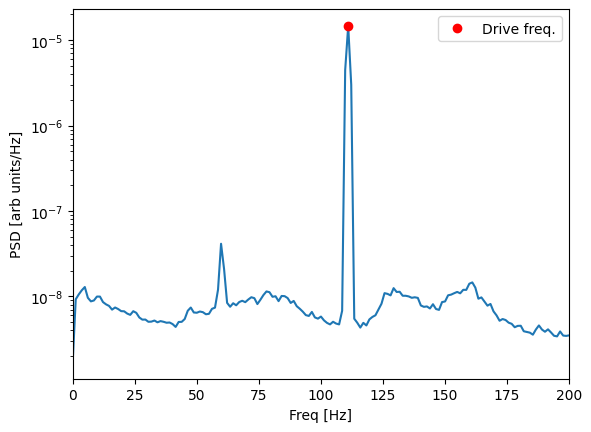

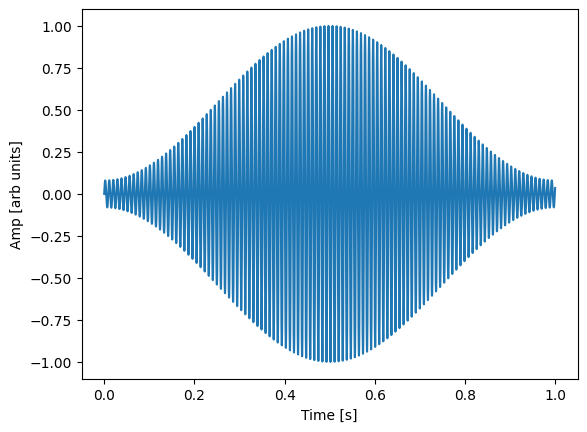

In [153]:
## make a template for the charge measurement
importlib.reload(bu)
dat, attr, _ = bu.get_data(data_list[0])
drive_template, drive_freq = bu.correlation_template_cw(dat, attr, length=1, make_plots=True)

In [154]:
## process data to find charge correlation
importlib.reload(bu)

num_pts_per_charge_recon = 2**16 ## points to use in each fft segment for charge reconstruction

if(remake_files):
    charge_vec = []
    corr_vec = []
    for i,f in enumerate(data_list):

        if(i%10 == 0): print("working on file %d: %s"%(i, f))
        
        cdat, attr, fhandle = bu.get_data(f)
        if(not fhandle):
            continue    

        fname = "corr_%d.png"%i
        #corr_val, curr_corr_vec = bu.simple_correlation_with_drive(cdat, attr, drive_freq, bw=1, decstages=50)
        curr_corr_vec = bu.signed_correlation_with_drive(cdat, attr, nperseg=num_pts_per_charge_recon)
        if(i == 0):
            corr_vec = 1.0*curr_corr_vec
        else:
            corr_vec = np.vstack((corr_vec, curr_corr_vec))

        corr_val = np.median(curr_corr_vec[:,0])

        time = attr["Time"]
        charge_vec.append([time, corr_val])

    charge_vec = np.array(charge_vec)
    np.save(data_dir+"/charge_steps_%s.npy"%file_label, charge_vec)
    np.save(data_dir+"/charge_steps_vec_%s.npy"%file_label, corr_vec)
else:
    charge_vec = np.load(data_dir+"/charge_steps_%s.npy"%file_label)
    corr_vec = np.load(data_dir+"/charge_steps_vec_%s.npy"%file_label)

In [155]:
## Make a list of folder numbers and file names
cdat, attr, fhandle = bu.get_data(data_list[0])
num_pts_per_file = int(len(cdat[:,0])/num_pts_per_charge_recon)
folder_vec = []

for j,f in enumerate(data_list):
    parts = f.split('/')
    folder_vec.append([int(parts[5])]*num_pts_per_file)
folder_vec = np.ndarray.flatten(np.array(folder_vec))

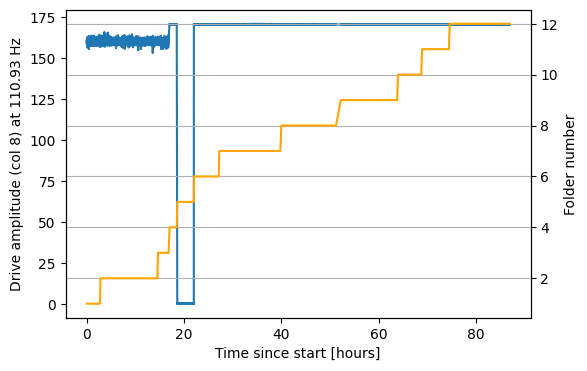

In [156]:
## plot the time correlation with the drive
time_hours = (corr_vec[:,-1]-corr_vec[0,-1])/3600

plt.figure(figsize =(6,4))
plt.plot(time_hours, corr_vec[:,3])
plt.xlabel("Time since start [hours]")
plt.ylabel("Drive amplitude (col 8) at 110.93 Hz")
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(time_hours, folder_vec, color='orange')
plt.ylabel("Folder number")
plt.grid(True)


/var/folders/35/ft5fljg94_x6xpzhzn_wtctr0000gn/T/ipykernel_56704/1520649627.py:29: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  dv2 = np.convolve(dv, sig.gaussian(N,N/4), mode='same')


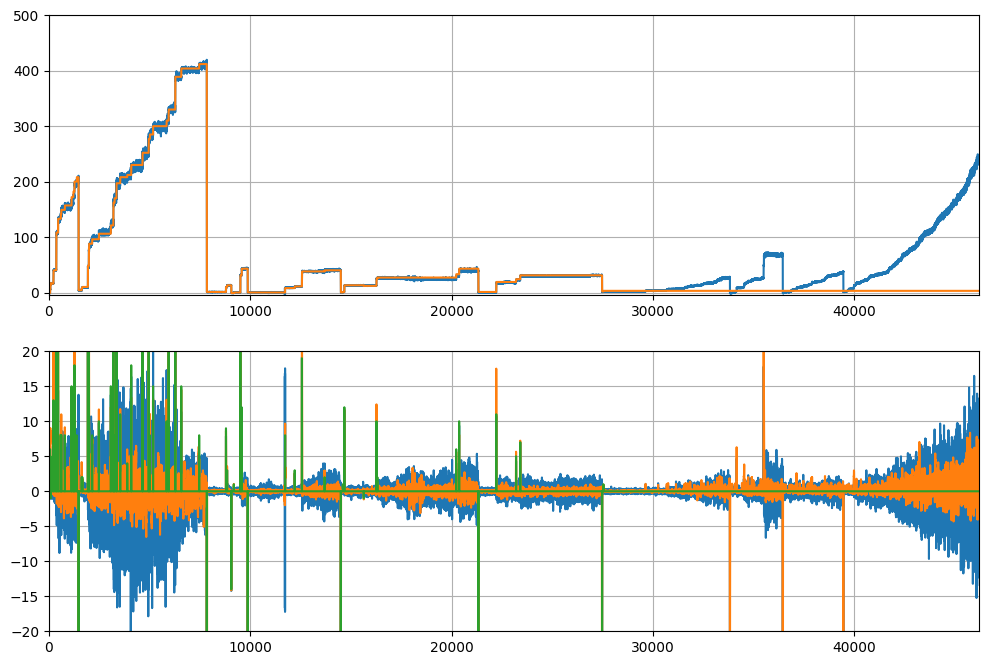

In [157]:
## initial plot of the charge steps versus time
cal_fac = 0.072
corr_idx = 2
recal = np.ones_like(corr_vec[1:,corr_idx])
recal[1500:7839] = 0.95


xmin, xmax = 0, len(corr_vec)
ymin, ymax = -5, 500
init_charge = -1

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
#plt.plot(corr_vec[1:,1]/cal_fac*recal, '-')
plt.plot(corr_vec[1:,corr_idx]/cal_fac*recal, '-')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(True)

plt.subplot(2,1,2)
dv = np.diff(corr_vec[:,corr_idx]/cal_fac)
plt.plot(dv)
b,a = sig.butter(3,0.3)
dv2 = sig.filtfilt(b,a,dv)
dv_chopped = np.round(dv)
bpts = (np.abs(dv) < 2) | (np.abs(dv) < 0.07*corr_vec[:-1, corr_idx]/cal_fac)
dv_chopped[bpts] = 0
N=25
dv2 = np.convolve(dv, sig.gaussian(N,N/4), mode='same')
plt.plot(dv2)
## fix up missed steps
step_vals = np.loadtxt(data_dir+"/step_locations_%s.txt"%file_label, skiprows=1, delimiter=',')
for i in range(np.shape(step_vals)[0]):
    cvals = step_vals[i,:]
    if(cvals[1] > 0):
        dv_chopped[int(cvals[0]):int(cvals[1])] = cvals[2]
    else:
        dv_chopped[int(cvals[0])] = cvals[2]

plt.plot(dv_chopped)
plt.xlim(xmin, xmax)
plt.ylim(-20,20)
plt.grid(True)

running_charge = np.cumsum(dv_chopped) + init_charge
plt.subplot(2,1,1)
plt.plot(running_charge, '-')

In [158]:
## make a dead time vector
live_vec = 1.0*time_hours
bad_pts = (time_hours > 56) | ((time_hours>18.575) & (time_hours<22.007))# (folder_vec == 5) | (time_hours > 55)
live_vec = live_vec[~bad_pts]

time_separation = np.diff(live_vec)
dead_periods = np.where(time_separation > 0.01)[0] ## count any deadtime > 30 seconds
dead_period_edges = []
for j,dp in enumerate(dead_periods):
    dead_period_edges.append([live_vec[dp], live_vec[dp+1]])
dead_period_edges.append([live_vec[-1], time_hours[-1]])


In [159]:
## define plotting function for dead times
def fill_dps():
    yy = plt.ylim()
    for i,dp in enumerate(dead_period_edges):
        if(i==0):
            plt.fill_between(dp, [yy[0],yy[0]], [yy[1],yy[1]], color='blue', alpha=0.2, label="Dead time")
        else:
            plt.fill_between(dp, [yy[0],yy[0]], [yy[1],yy[1]], color='blue', alpha=0.2)  
    plt.ylim(yy)

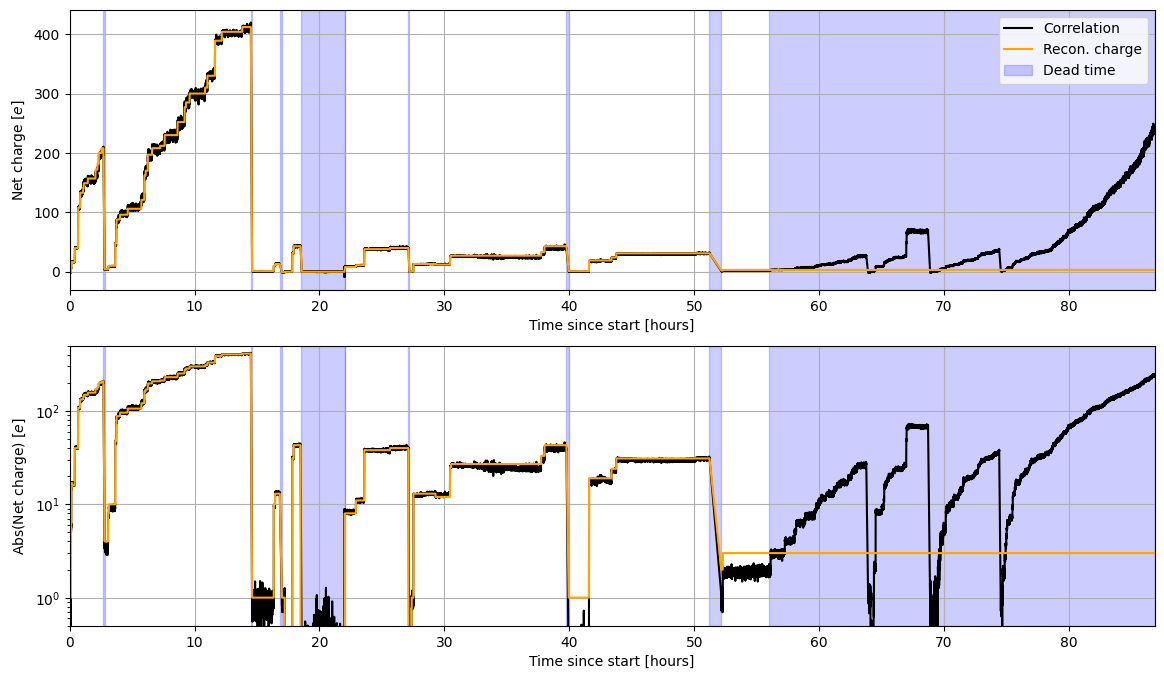

In [160]:
## now make some cleaned up versions of the charge step plots versus time
plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
#plt.plot(corr_vec[1:,1]/cal_fac*recal, '-')
plt.plot(time_hours[1:], corr_vec[1:,corr_idx]/cal_fac*recal, 'k-', label="Correlation")
plt.plot(time_hours[1:], running_charge, '-', color='orange', label="Recon. charge")
plt.grid(True)
fill_dps()
plt.xlim(time_hours[0], time_hours[-1])
plt.xlabel("Time since start [hours]")
plt.ylabel("Net charge [$e$]")
plt.legend(loc="upper right")

plt.subplot(2,1,2)
plt.semilogy(time_hours[1:], np.abs(corr_vec[1:,corr_idx]/cal_fac*recal), 'k-', label="Correlation")
plt.plot(time_hours[1:], np.abs(running_charge), '-', color='orange', label="Recon. charge")
plt.grid(True)
plt.ylim(0.5,500)
fill_dps()
plt.xlim(time_hours[0], time_hours[-1])
plt.ylabel("Abs(Net charge) [$e$]")
plt.xlabel("Time since start [hours]")

plt.savefig(plots_dir+"/recon_charge_vs_time_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [161]:
## find the locations of the charge changes
all_bad_periods = dead_period_edges
bad_pts = np.zeros_like(time_hours[:-1], dtype=bool)
for dp in all_bad_periods:
    bad_pts = bad_pts | ((time_hours[:-1] >= dp[0]) & (time_hours[:-1] <= dp[1]))

min_change = -10
changes = (np.abs(dv_chopped) > 0) & (dv_chopped > min_change) & ~bad_pts
big_changes = (np.abs(dv_chopped) >= 8) & (dv_chopped > min_change) & ~bad_pts


## group consecutive changes
idx_of_charge_changes = np.where(changes)[0]
dup_changes = np.diff(idx_of_charge_changes) <= 2
good_change_list = [ [time_hours[idx_of_charge_changes[0]], dv_chopped[idx_of_charge_changes[0]], running_charge[idx_of_charge_changes[0]-1]] ] 
for j in range(1,len(idx_of_charge_changes)):
    is_dup = dup_changes[j-1]
    if(is_dup):
        good_change_list[-1][1] += dv_chopped[idx_of_charge_changes[j]]
        continue
    good_change_list.append([time_hours[idx_of_charge_changes[j]], dv_chopped[idx_of_charge_changes[j]], running_charge[idx_of_charge_changes[j]-1]])

good_change_list = np.array(good_change_list)

In [162]:
#save the step locations
np.savez(data_dir+"/charge_data_%s.npz"%file_label, time_hours=time_hours, corr_vec=corr_vec, dv_chopped=dv_chopped, running_charge=running_charge, 
         dead_period_edges=dead_period_edges, cal_fac=cal_fac,corr_idx=corr_idx,
         good_change_list=good_change_list, all_bad_periods=all_bad_periods)

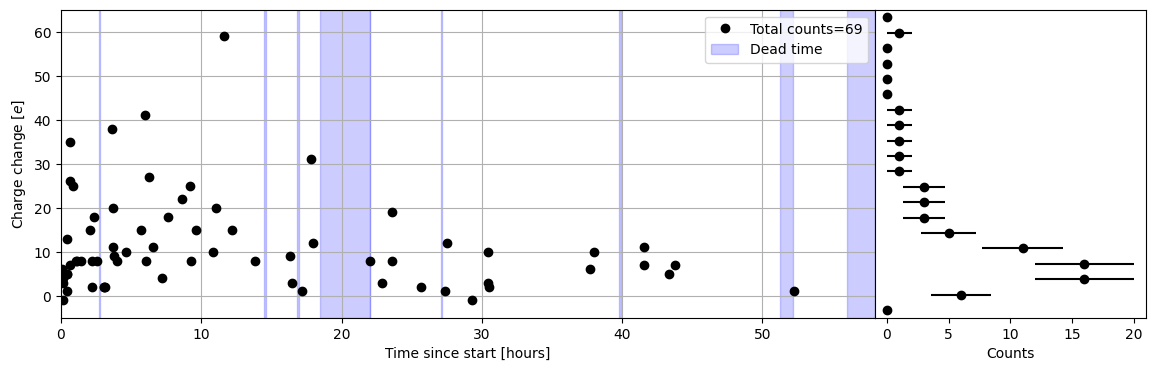

In [163]:
## find the locations of the charge changes
changes = (np.abs(dv_chopped) > 0) & (dv_chopped > -5)
big_changes = (np.abs(dv_chopped) >= 8) & (dv_chopped > -5)
fig, (scatter_ax, hist_ax) = plt.subplots(1, 2, figsize=(14, 4), width_ratios=[3,1])
#plt.plot(time_hours[1:], dv_chopped, 'k')
plt.sca(scatter_ax)
scatter_ax.plot(time_hours[1:][changes], dv_chopped[changes], 'ko', label='Total counts=%d'%np.sum(changes))
plt.ylim(-5,65)
fill_dps()
plt.grid(True)
plt.xlim(0, 58)
plt.ylabel("Charge change [$e$]")
plt.xlabel("Time since start [hours]")
plt.legend()

hh, be = np.histogram(dv_chopped[changes], bins=20, range=(-5,65))
bc = be[:-1] + np.diff(be)/2
#plt.step(be[:-1], hh, where='post', color='k')
plt.sca(hist_ax)
hist_ax.errorbar(hh, bc, xerr=np.sqrt(hh), fmt='ko')
plt.yticks([])
plt.ylim(-5,65)
plt.xlabel("Counts")
plt.subplots_adjust(wspace=0)

plt.savefig(plots_dir+"/charge_changes_vs_time_%s.png"%file_label, dpi=300, bbox_inches="tight")

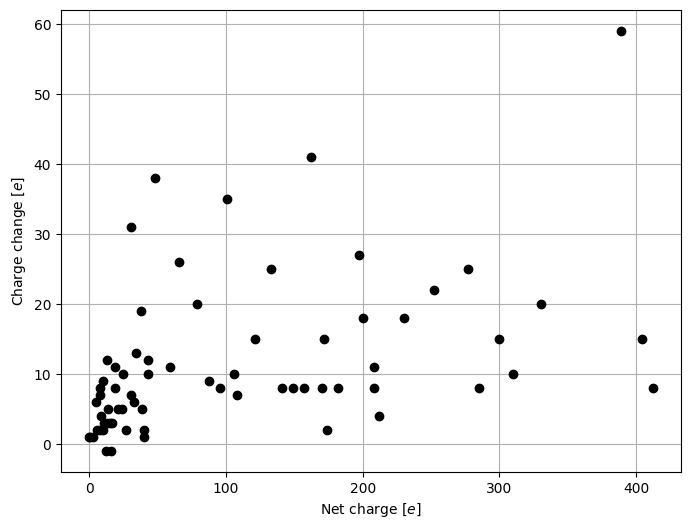

In [164]:
plt.figure(figsize=(8,6))
plt.plot(running_charge[changes], dv_chopped[changes], 'ko')
plt.xlabel("Net charge [$e$]")
plt.ylabel("Charge change [$e$]")
plt.grid(True)
plt.savefig(plots_dir+"/charge_changes_vs_charge_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [165]:
def lfun(t, N0, t12, tot_time=56, use_norm=True):
    tint = np.linspace(0, tot_time, 1000)
    norm = np.trapz(0.5**(tint/t12))
    if(use_norm):
        val = 1/norm * 0.5**(t/t12)
    else:
        val = N0 * 0.5**(t/t12)
    bad_pts = np.zeros_like(t)
    for dp in dead_period_edges:
        inrange = ((t > dp[0]) & (t < dp[1]))
        bad_pts = np.logical_or(bad_pts, inrange)
    val[bad_pts] = 0
    return val

def nll(t, N0, t12, tot_time=56):
    N = len(t)
    mu = N0*(1 - 0.5**(tot_time/t12))
    poiss = N*np.log(mu) - mu
    return -np.sum(np.log(lfun(t, 1, t12))) - poiss

4.454091826830295 4.398438829247506


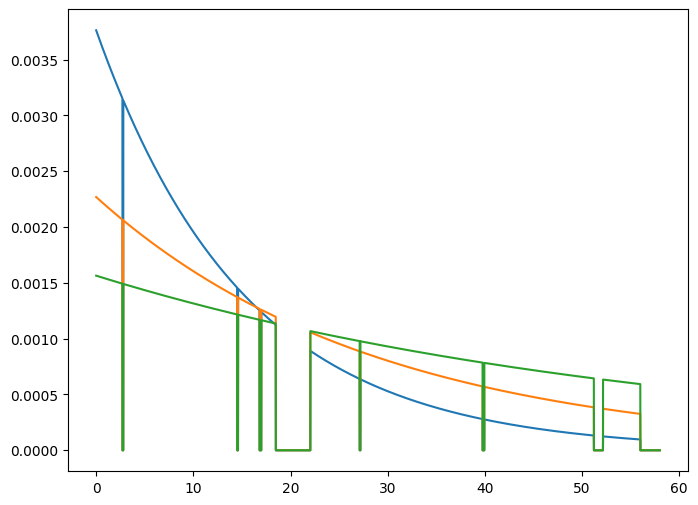

In [166]:
t = np.linspace(0, 58, 5000)
plt.figure(figsize=(8,6))
plt.plot(t, lfun(t, 1, 10.6))
plt.plot(t, lfun(t, 1, 20))
plt.plot(t, lfun(t, 1, 40))
print(np.trapz(lfun(t, 1, 10.6)),np.trapz(lfun(t, 1, 20)))

In [167]:
## time of decays/half life
decay_times = time_hours[1:][changes]
big_decay_times = time_hours[1:][big_changes]

## likelihood fit
N0_vec = np.linspace(0, 150, 210)
t12_vec = np.linspace(0.5, 25, 200)
nll_mat_all = np.zeros((len(N0_vec), len(t12_vec)))
nll_mat_big = np.zeros((len(N0_vec), len(t12_vec)))

for i,N0 in enumerate(N0_vec):
    for j,t12 in enumerate(t12_vec):
        nll_mat_all[i,j] = nll(decay_times, N0, t12)
        nll_mat_big[i,j] = nll(big_decay_times, N0, t12)

nll_mat_all -= np.min(nll_mat_all)
nll_mat_big -= np.min(nll_mat_big)

/var/folders/35/ft5fljg94_x6xpzhzn_wtctr0000gn/T/ipykernel_56704/2829892270.py:18: RuntimeWarning: divide by zero encountered in log
  poiss = N*np.log(mu) - mu


/var/folders/35/ft5fljg94_x6xpzhzn_wtctr0000gn/T/ipykernel_56704/202428269.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(t12_vec, profile_nll, 'k', label="Fit = $%.1f^{+%.1f}_{-%.1f}$ hr"%(cv, uv-cv, cv-lv))


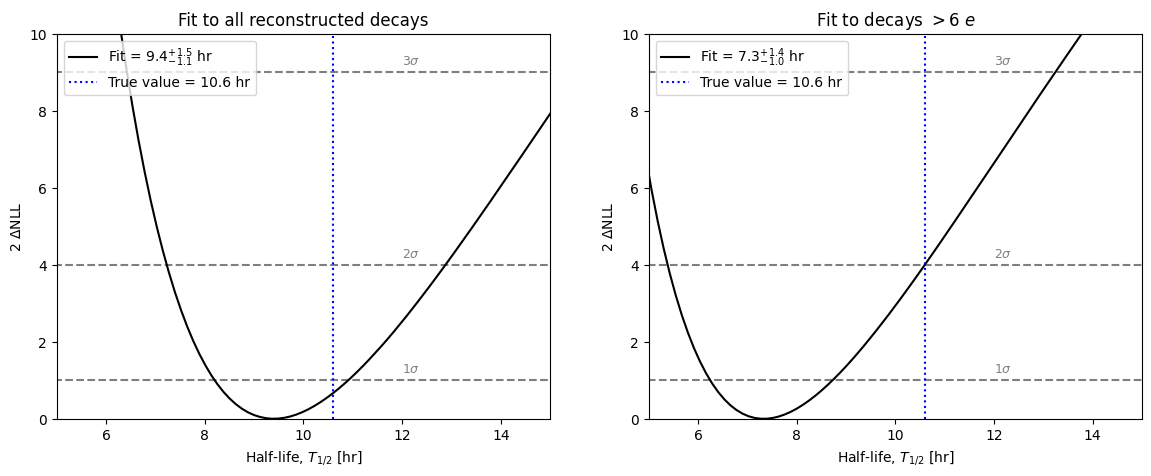

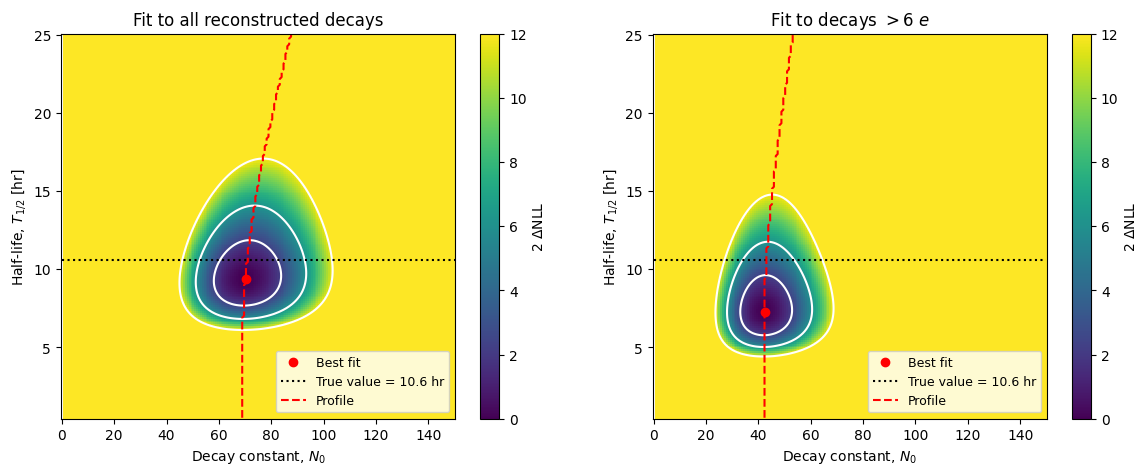

In [168]:
t12_true = 10.6 ## https://www.nndc.bnl.gov/nudat3/DecayRadiationServlet?nuc=212Pb&unc=NDS

nlls = [nll_mat_all, nll_mat_big]
labs = ["Fit to all reconstructed decays", "Fit to decays $>6$ $e$"]

fig1d = plt.figure(figsize=(14,5))
fig2d = plt.figure(figsize=(14,5))
params_from_profile = []
for j in range(2):

    profile = np.zeros_like(t12_vec)
    profile_nll = np.zeros_like(t12_vec)
    for k in range(len(t12_vec)):
        profile[k] = N0_vec[np.argmin(nlls[j][:,k])]
        profile_nll[k] = 2*np.min(nlls[j][:,k])

    plt.figure(fig1d.number)
    plt.subplot(1,2,j+1)
    cup = np.where((profile_nll <= 1) & (np.roll(profile_nll,-1) > 1))[0]
    clo = np.where((profile_nll <= 1) & (np.roll(profile_nll,1) > 1))[0]
    cv, uv, lv = t12_vec[np.argmin(profile_nll)], t12_vec[cup], t12_vec[clo]
    plt.plot(t12_vec, profile_nll, 'k', label="Fit = $%.1f^{+%.1f}_{-%.1f}$ hr"%(cv, uv-cv, cv-lv))
    plt.ylim(0, 10)
    levels = [1, 4, 9]
    for lidx, l in enumerate(levels):
        plt.plot(t12_vec, l*np.ones_like(t12_vec), 'k--', alpha=0.5)
        plt.text(12, l+0.2, "$%d\sigma$"%(lidx+1), fontsize=9, color='gray')
    plt.plot([t12_true, t12_true], [0, 10], 'b:', label="True value = %.1f hr"%t12_true)
    plt.xlim(5,15)
    plt.xlabel("Half-life, $T_{1/2}$ [hr]")
    plt.ylabel("2 $\Delta$NLL")
    plt.legend(loc="upper left")
    plt.title(labs[j])

    plt.figure(fig2d.number)
    plt.subplot(1,2,j+1)
    plt.pcolormesh(N0_vec, t12_vec, 2*nlls[j].T, cmap='viridis', vmin=0, vmax=12)
    plt.colorbar(label="2 $\Delta$NLL")
    min_loc = np.argmin(nlls[j].T)
    N0_mesh, t12_mesh = np.meshgrid(N0_vec, t12_vec)
    plt.plot( np.ndarray.flatten(N0_mesh)[min_loc], np.ndarray.flatten(t12_mesh)[min_loc], 
             'ro', label="Best fit")

    plt.contour( N0_vec, t12_vec, 2*nlls[j].T, levels=[2.3, 6.17, 11.8], colors='w')
    plt.xlabel("Decay constant, $N_0$")
    plt.ylabel("Half-life, $T_{1/2}$ [hr]")
    plt.plot(N0_vec, t12_true*np.ones_like(N0_vec), 'k:', label="True value = %.1f hr"%t12_true)
    plt.title(labs[j])

    ## plot the profile
    plt.plot(profile, t12_vec, 'r--', label= "Profile")
    bpN0, bpt12 = np.ndarray.flatten(N0_mesh)[min_loc], np.ndarray.flatten(t12_mesh)[min_loc]
    bpN0_lo, bpt12_lo = profile[clo], t12_vec[clo]
    bpN0_hi, bpt12_hi = profile[cup], t12_vec[cup]
    params_from_profile.append([bpN0, bpt12, bpN0_lo, bpt12_lo, bpN0_hi, bpt12_hi])

    plt.legend(loc='lower right', fontsize=9)

plt.figure(fig1d.number)
plt.savefig(plots_dir+"/profile_1d_%s.png"%file_label, dpi=300, bbox_inches="tight")
plt.figure(fig2d.number)
plt.savefig(plots_dir+"/profile_2d_%s.png"%file_label, dpi=300, bbox_inches="tight")

plt.show()

[70.33492822966507, 9.364321608040202, array([69.61722488]), array([8.25628141]), array([71.05263158]), array([10.84170854])]
[42.3444976076555, 7.2713567839195985, array([42.34449761]), array([6.28643216]), array([42.34449761]), array([8.62562814])]


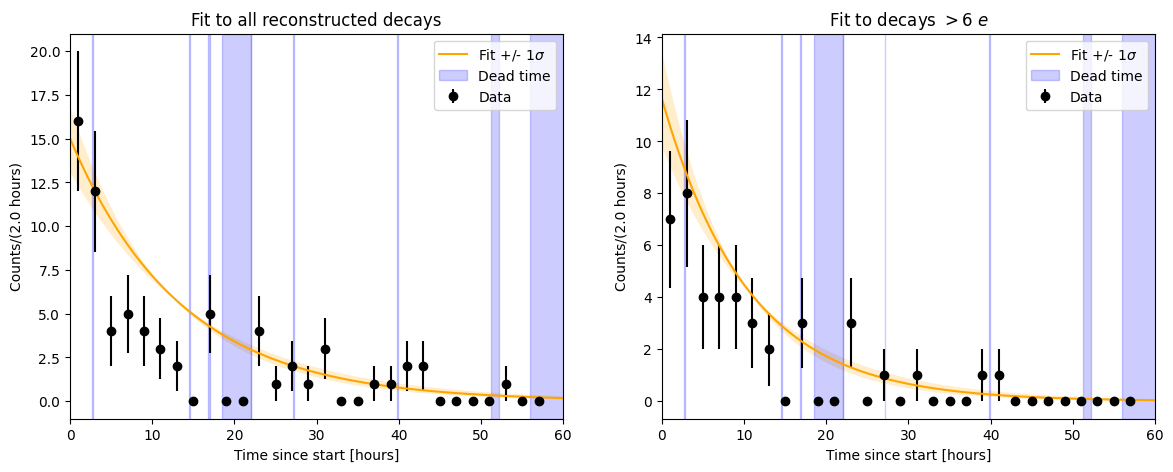

In [169]:
nbins = 29

decay_times_list = [decay_times, big_decay_times]

plt.figure(figsize=(14,5))
for j in range(2):
    hh,be = np.histogram(decay_times_list[j], bins=nbins, range=(0,58))
    bc = be[:-1] + np.diff(be)/2

    bin_length = be[1]-be[0]

    plt.subplot(1,2,j+1)
    plt.errorbar( bc, hh, yerr=np.sqrt(hh), fmt='ko', label="Data")
    curr_bp = params_from_profile[j]
    xx = np.linspace(0,60,1000)
    yy = bin_length*curr_bp[0]/curr_bp[1] * 0.5**(xx/curr_bp[1])
    ylo = bin_length*curr_bp[2]/curr_bp[3] * 0.5**(xx/curr_bp[3])
    yhi = bin_length*curr_bp[4]/curr_bp[5] * 0.5**(xx/curr_bp[5])
    print(curr_bp)
    plt.plot(xx, yy, color='orange', label="Fit +/- 1$\sigma$")
    plt.fill_between(xx, ylo, yhi, color='orange', alpha=0.2, edgecolor=None)
    #plt.errorbar( bc, hh2, yerr=np.sqrt(hh2), fmt='o', color='orange', markerfacecolor='None', label="Recon $\geq$6$e$")
    fill_dps()
    plt.xlabel("Time since start [hours]")
    plt.ylabel("Counts/(%.1f hours)"%(bin_length))
    plt.xlim(0,60)
    plt.title(labs[j])
    plt.legend()

plt.savefig(plots_dir+"/decays_vs_time_%s.png"%file_label, dpi=300, bbox_inches="tight")

[70.33492822966507, 9.364321608040202, array([69.61722488]), array([8.25628141]), array([71.05263158]), array([10.84170854])]


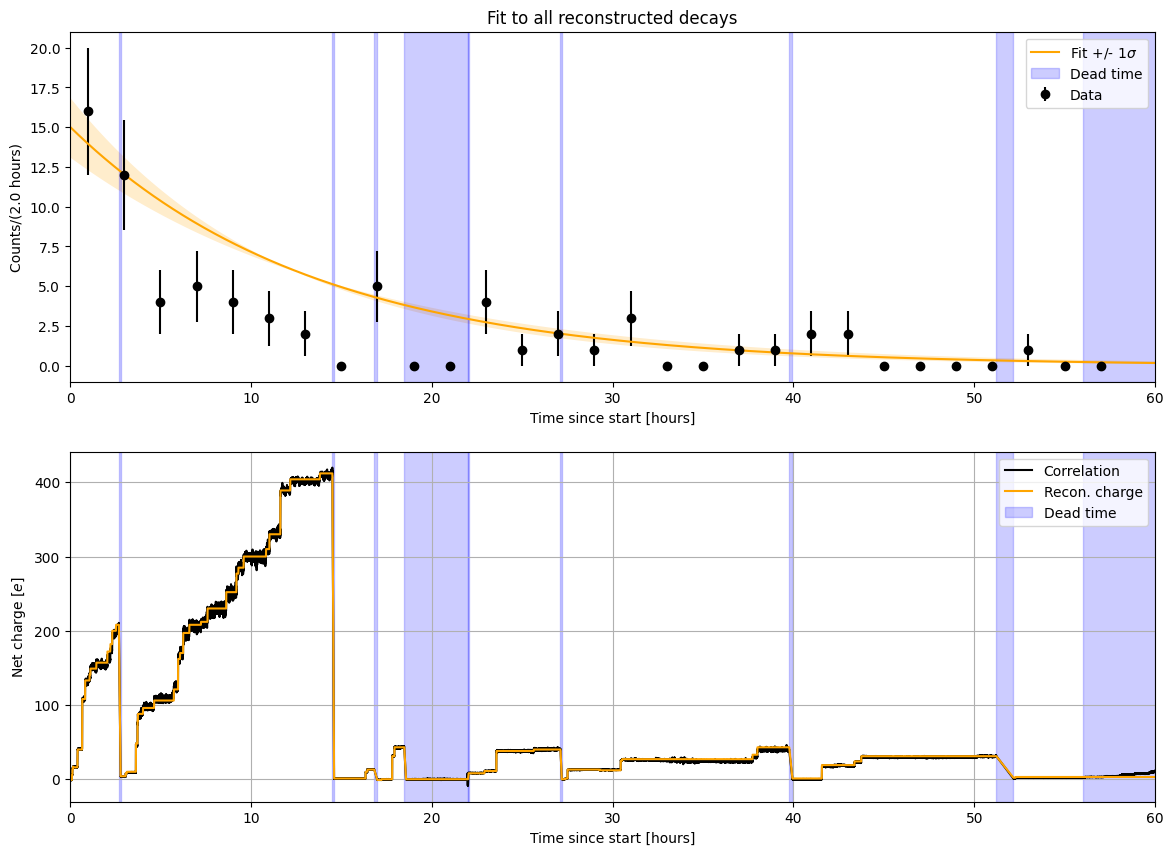

In [170]:
nbins = 29

decay_times_list = [decay_times, big_decay_times]

plt.figure(figsize=(14,10))
for j in range(1):
    hh,be = np.histogram(decay_times_list[j], bins=nbins, range=(0,58))
    bc = be[:-1] + np.diff(be)/2

    bin_length = be[1]-be[0]

    plt.subplot(2,1,j+1)
    plt.errorbar( bc, hh, yerr=np.sqrt(hh), fmt='ko', label="Data")
    curr_bp = params_from_profile[j]
    xx = np.linspace(0,60,1000)
    yy = bin_length*curr_bp[0]/curr_bp[1] * 0.5**(xx/curr_bp[1])
    ylo = bin_length*curr_bp[2]/curr_bp[3] * 0.5**(xx/curr_bp[3])
    yhi = bin_length*curr_bp[4]/curr_bp[5] * 0.5**(xx/curr_bp[5])
    print(curr_bp)
    plt.plot(xx, yy, color='orange', label="Fit +/- 1$\sigma$")
    plt.fill_between(xx, ylo, yhi, color='orange', alpha=0.2, edgecolor=None)
    #plt.errorbar( bc, hh2, yerr=np.sqrt(hh2), fmt='o', color='orange', markerfacecolor='None', label="Recon $\geq$6$e$")
    fill_dps()
    plt.xlabel("Time since start [hours]")
    plt.ylabel("Counts/(%.1f hours)"%(bin_length))
    plt.xlim(0,60)
    plt.title(labs[j])
    plt.legend()

plt.subplot(2,1,2)
plt.plot(time_hours[1:], corr_vec[1:,corr_idx]/cal_fac*recal, 'k-', label="Correlation")
plt.plot(time_hours[1:], running_charge, '-', color='orange', label="Recon. charge")
plt.grid(True)
fill_dps()
plt.xlim(time_hours[0], time_hours[-1])
plt.xlabel("Time since start [hours]")
plt.ylabel("Net charge [$e$]")
plt.legend(loc="upper right")
plt.xlim(0,60)

plt.savefig(plots_dir+"/decays_vs_time_with_charge_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [171]:
def exp_fun(x, A, t12=10.6):
    lam = np.log(2)/t12
    return A*np.exp(-lam*x)

In [172]:
time_between = np.diff(decay_times)
dt = (time_hours[1]-time_hours[0])
gpts = time_between>1.1*dt
time_between = time_between[gpts]

[16.44119128 17.9373863  27.51355905 30.53415811]


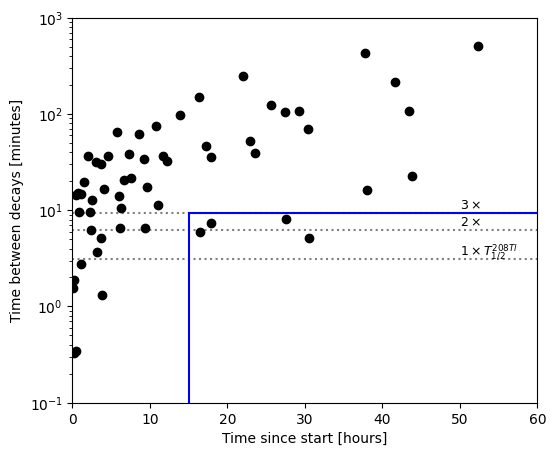

In [173]:
plt.figure(figsize=(6,5))
plt.semilogy(decay_times[1:][gpts], time_between*60, 'ko')
plt.xlim(0,60)
plt.ylim(0.1,1e3)
t12_tl208 = 3.1
for i in range(1,4):
    plt.plot([0,60], [i*t12_tl208, i*t12_tl208], 'k:', alpha=0.5)
    if(i==1):
        plt.text(50, i*t12_tl208*1.1, r"$%d \times T_{1/2}^{208Tl}$"%(i), fontsize=9, color='k')
    else:
        plt.text(50, i*t12_tl208*1.1, r"$%d \times$"%(i), fontsize=9, color='k')

xcut, ycut = 15, 9.3

all_times = decay_times[1:][gpts]
cut_pos = (all_times > xcut) & (time_between*60 < ycut)
cand_decay_times = all_times[cut_pos]
bi_decay_times = all_times[np.roll(cut_pos,-1)]
print(cand_decay_times)

plt.plot( [xcut,xcut], [0.1, ycut], 'b')
plt.plot( [xcut,60], [ycut, ycut], 'b')
plt.xlabel("Time since start [hours]")
plt.ylabel("Time between decays [minutes]")

plt.savefig(plots_dir+"/time_between_tl208_%s.png"%file_label, dpi=300, bbox_inches="tight")

plt.show()

T12 = 18.2 +/- 2.4


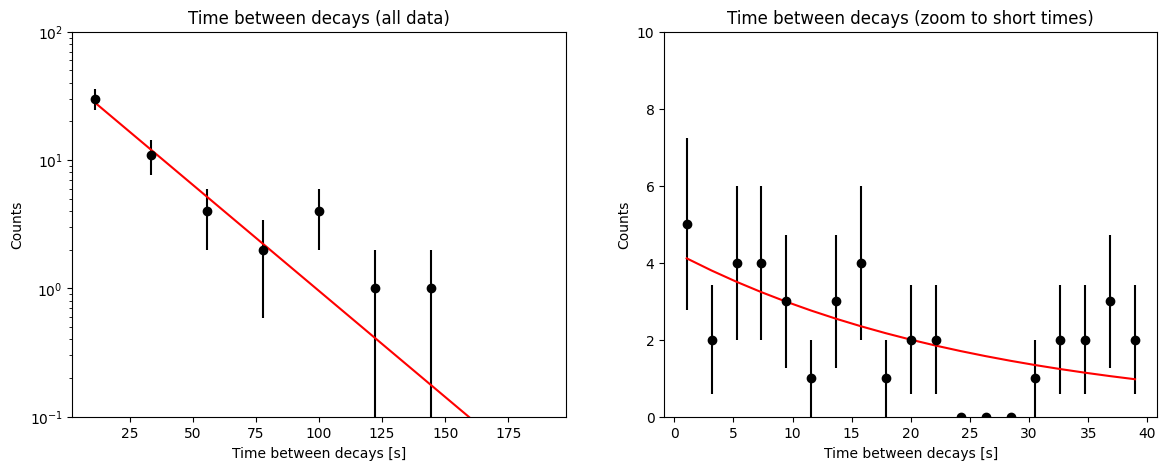

In [174]:
tbins = np.linspace(0,200,10)
hh, be = np.histogram(time_between*60, bins=tbins)
bc = be[:-1] + np.diff(be)/2

err = np.sqrt(hh)
err[err==0] = 1
bp, bcov = opt.curve_fit(exp_fun, bc, hh, p0=[100, 10.6*60], sigma=err)
print("T12 = %.1f +/- %.1f"%(bp[1], np.sqrt(bcov[1,1])))
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='ko')
plt.plot(bc, exp_fun(bc, *bp), 'r')
plt.gca().set_yscale("log")
plt.ylim(0.1,100)
plt.xlabel("Time between decays [s]")
plt.ylabel("Counts")
plt.title("Time between decays (all data)")

plt.subplot(1,2,2)
tbins = np.linspace(0,40,20)
hh, be = np.histogram(time_between*60, bins=tbins)
bc = be[:-1] + np.diff(be)/2

plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='ko')
plt.plot(bc, exp_fun(bc, *bp)/10, 'r')
#plt.gca().set_yscale("log")
plt.ylim(0,10)
plt.xlabel("Time between decays [s]")
plt.ylabel("Counts")
plt.title("Time between decays (zoom to short times)")

plt.savefig(plots_dir+"/time_between_fits_%s.png"%file_label, dpi=300, bbox_inches="tight")
plt.show()


8792
9506
14598
16265


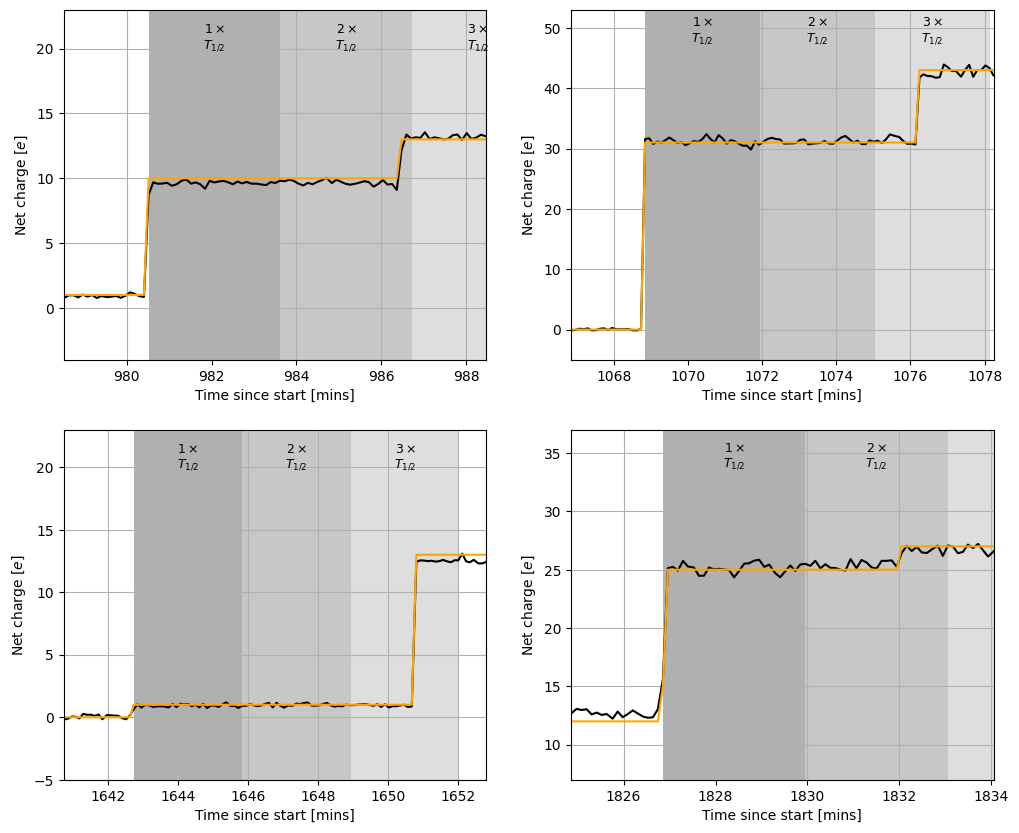

In [175]:
## now find the Tl-208 candidate decays and plot a zoom

low_wind, high_wind = 2, 2
hrs_to_mins = 60

plt.figure(figsize=(12,10))
figidx = 1
for bi_hrs,cdt_hrs in zip(bi_decay_times,cand_decay_times):

    cdt = cdt_hrs*hrs_to_mins
    cdt_bi = bi_hrs*hrs_to_mins

    idx_of_bi = np.argmin(np.abs(time_hours[1:]*hrs_to_mins - cdt_bi))
    bi_time = time_hours[1:][idx_of_bi]*hrs_to_mins
    print(idx_of_bi)

    plt.subplot(2,2,figidx)
    plt.plot(time_hours[1:]*hrs_to_mins, corr_vec[1:,corr_idx]/cal_fac*recal, 'k-', label="Correlation")
    plt.plot(time_hours[1:]*hrs_to_mins, running_charge, '-', color='orange', label="Recon. charge")
    plt.grid(True)
    fill_dps()
    plt.xlim(cdt_bi-low_wind, cdt+high_wind)
    gpts = (time_hours[1:]*hrs_to_mins > cdt_bi-low_wind) & (time_hours[1:]*hrs_to_mins < cdt+high_wind)
    y1, y2 = np.min(running_charge[gpts])-5, np.max(running_charge[gpts])+10
    plt.ylim(y1,y2)
    for i in range(1,4):
        plt.fill_between([bi_time+(i-1)*t12_tl208, bi_time+i*t12_tl208], [y1, y1], [y2, y2], color='k', alpha=0.4-(i*0.09),edgecolor=None)
        xp = np.mean([bi_time+(i-1)*t12_tl208, bi_time+i*t12_tl208])
        if(xp > cdt+high_wind): break
        plt.text(xp, y2-1, r"$%d \times$"%i +"\n$T_{1/2}$", fontsize=9, color='k', verticalalignment='top', horizontalalignment='center')
    plt.xlabel("Time since start [mins]")
    plt.ylabel("Net charge [$e$]")
    figidx+=1
    #plt.legend(loc="upper left")
    plt.savefig(plots_dir+"/candidate_bi_tl_%s.png"%file_label, dpi=300, bbox_inches="tight")

16.0


(100.0, 120.0)

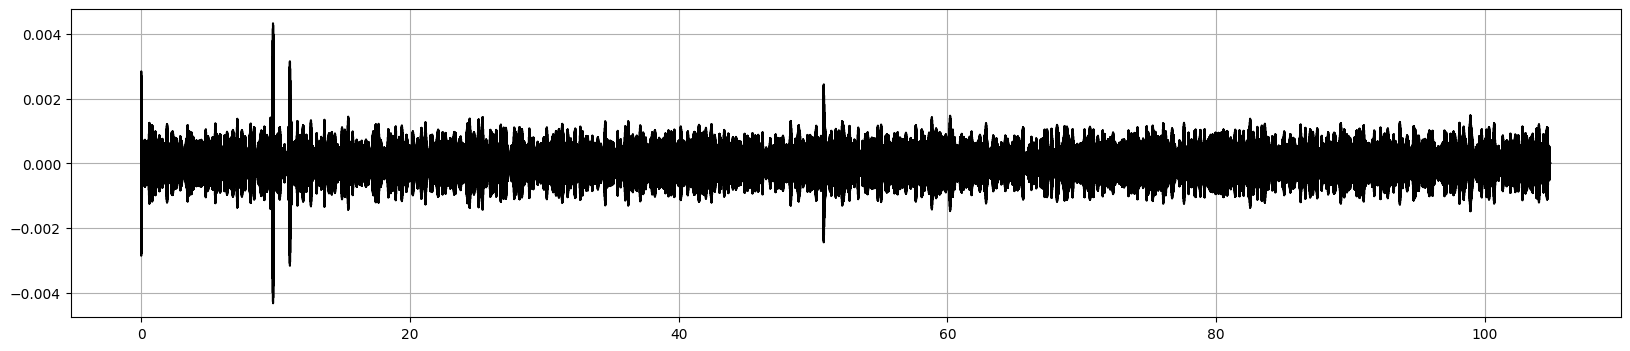

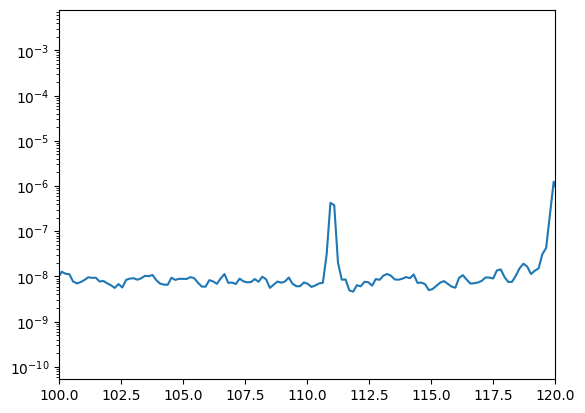

In [176]:
## code to plot individual files charge change
#cdat, attr, fhandle = bu.get_data(data_list[int(1210/16)])
idx=916*16
nfiles = 1
plt.figure(figsize=(20,4))
for nf in range(nfiles):
    cdat, attr, fhandle = bu.get_data(data_list[int(idx/16)+nf])  ## correlated decays 20 s apart?
    fn = np.array([104, 117])/5000
    #fn = np.array([110.5, 111.5])/5000
    b,a = sig.butter(3, fn, btype='bandpass')
    fdat = sig.filtfilt(b,a,cdat[:,0])
    print(len(fdat)/2**16)

    tvec = np.arange(0, len(fdat))/1e4 + nf*(len(fdat)-1)/1e4


    plt.plot(tvec,fdat, 'k')
    plt.grid(True)
    #plt.xlim(50,58)
    #plt.ylim(0.06, 0.10)

plt.figure()
f,p = sig.welch(cdat[:,0], fs=1e4,nperseg=2**16)
plt.semilogy(f,p)
plt.xlim(100,120)

Now let's analyze whether there are any kicks correlated with the charge changes:

In [177]:
## create list of calibration files 
calib_file_dict = {}
for curr_path in calib_data:
    curr_file_list = natsorted(glob.glob(os.path.join(base_path, curr_path, "**MeV/*.h5"), recursive=True))

    for file in curr_file_list:
        impulse_amp = bu.parse_impulse_amplitude(file)
        if impulse_amp in calib_file_dict.keys():
            calib_file_dict[impulse_amp].append(file)
        else:
            calib_file_dict[impulse_amp] = [file,]

noise_file_list = []
for curr_path in calib_noise_path:
    curr_file_list = natsorted(glob.glob(os.path.join(base_path, curr_path, "*.h5"), recursive=True))
    if(len(noise_file_list)>0):
        noise_file_list.append(curr_file_list)
    else:
        noise_file_list = curr_file_list

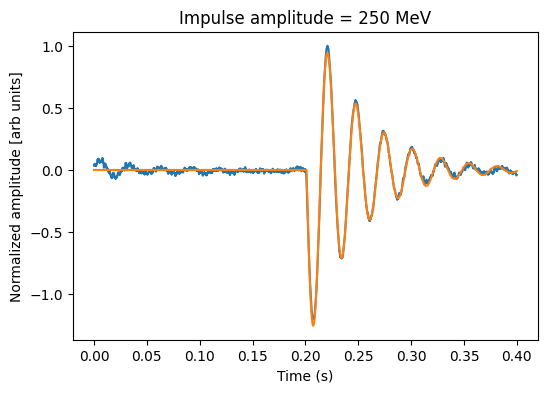

In [178]:
# calculate the pulse tempates by averaging all calibration files
importlib.reload(bu)
template_dict, template_dict_fit, fit_vals = bu.get_average_template(calib_file_dict, make_plots=True, 
                                                                     fit_pars=[-1,2*np.pi*30,10,0.20], drive_idx=10)

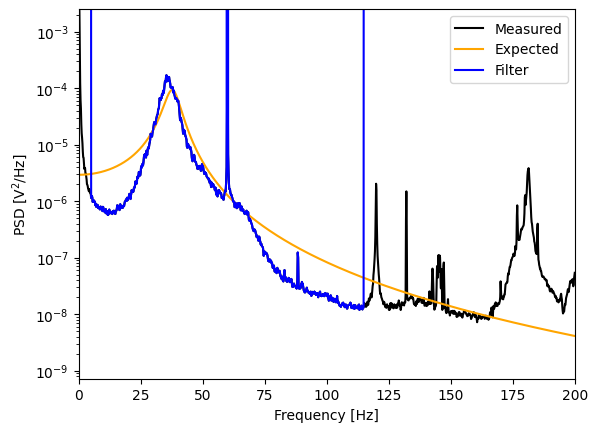

In [179]:
## noise from the same time as the calibration
importlib.reload(bu)
res_pars = [np.median(fit_vals[:,1]), np.median(fit_vals[:,3])]
noise_dict = bu.get_noise_template(noise_file_list, res_pars=res_pars, nfft=2**16)

In [180]:
importlib.reload(bu)
opt_filt_amps, phi_t = bu.optimal_filt(calib_file_dict, template_dict_fit, noise_dict, time_offset=-12, drive_idx=10, cal_fac=288.5, make_plots=False)
time_corr_amps = bu.correlation_filt(calib_file_dict, template_dict_fit, bandpass=[5,70], notch_list = [], drive_idx=10, make_plots=False)
bandpass_amps = bu.bandpass_filt(calib_file_dict, template_dict_fit, time_offset=0, bandpass=[5,70], drive_idx=10, cal_fac = 7550, make_plots=False)

/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis/bead_utils.py:1112: RuntimeWarning: invalid value encountered in sqrt
  corr_data = np.sqrt(sp.filtfilt(bcorr, acorr, corr_data**2))


In [181]:
## calculate pedestal with search bias by time offset away from pulse
opt_filt_pedestal, _ = bu.optimal_filt(calib_file_dict, template_dict_fit, noise_dict, time_offset=2000, drive_idx=10, cal_fac=288.5, make_plots=False)
bandpass_pedestal = bu.bandpass_filt(calib_file_dict, template_dict_fit, time_offset=-500, bandpass=[5,70], drive_idx=10, cal_fac = 7550, make_plots=False)

In [182]:
## create list of calibration files 
calib_file_dict = {}
coords_to_calib = ['x', 'y', 'z']

for curr_path in calib_data:

    for coord in coords_to_calib:
        if(coord == 'x'):
            fpath = os.path.join(base_path, curr_path, "**MeV/*.h5")
        else:
            continue

        curr_file_list = natsorted(glob.glob(fpath, recursive=True))

        for file in curr_file_list:
            impulse_amp = bu.parse_impulse_amplitude(file)

            if( coord in calib_file_dict.keys()):            
                if impulse_amp in calib_file_dict[coord].keys():
                    calib_file_dict[coord][impulse_amp].append(file)
                else:
                    calib_file_dict[coord][impulse_amp] = [file,] 
            else:
                calib_file_dict[coord] = {}
                calib_file_dict[coord][impulse_amp] = [file,]

calib_data_1030 = ["20231030/2/calibration/1", "20231030/2/calibration/2",]
for curr_path in calib_data_1030:

    for coord in coords_to_calib:
        if(coord != 'x'):
            fpath = os.path.join(base_path, curr_path, coord, "**MeV/*.h5")
        else:
            continue

        curr_file_list = natsorted(glob.glob(fpath, recursive=True))

        for file in curr_file_list:
            impulse_amp = bu.parse_impulse_amplitude(file)

            if( coord in calib_file_dict.keys()):            
                if impulse_amp in calib_file_dict[coord].keys():
                    calib_file_dict[coord][impulse_amp].append(file)
                else:
                    calib_file_dict[coord][impulse_amp] = [file,] 
            else:
                calib_file_dict[coord] = {}
                calib_file_dict[coord][impulse_amp] = [file,]

noise_file_list = []
for curr_path in calib_noise_path:
    curr_file_list = natsorted(glob.glob(os.path.join(base_path, curr_path, "*.h5"), recursive=True))
    if(len(noise_file_list)>0):
        noise_file_list += curr_file_list
    else:
        noise_file_list = curr_file_list

## no dedicated noise, so sample from throughout the run
if(len(noise_file_list) == 0):
    noise_file_list = data_list[::100]

In [183]:
calib_file_dict

{'x': {250.0: ['/Volumes/DATA/20230925/calibration/250MeV/LPmbar_xyzcool_0.h5',
   '/Volumes/DATA/20230925/calibration/250MeV/LPmbar_xyzcool_1.h5',
   '/Volumes/DATA/20230925/calibration/250MeV/LPmbar_xyzcool_2.h5']},
 'y': {300.0: ['/Volumes/DATA/20231030/2/calibration/1/y/300MeV/LPmbar_xyzcool_0.h5',
   '/Volumes/DATA/20231030/2/calibration/1/y/300MeV/LPmbar_xyzcool_1.h5',
   '/Volumes/DATA/20231030/2/calibration/1/y/300MeV/LPmbar_xyzcool_2.h5'],
  600.0: ['/Volumes/DATA/20231030/2/calibration/1/y/600MeV/LPmbar_xyzcool_0.h5',
   '/Volumes/DATA/20231030/2/calibration/1/y/600MeV/LPmbar_xyzcool_1.h5',
   '/Volumes/DATA/20231030/2/calibration/1/y/600MeV/LPmbar_xyzcool_2.h5'],
  250.0: ['/Volumes/DATA/20231030/2/calibration/2/y/250MeV/LPmbar_xyzcool_0.h5',
   '/Volumes/DATA/20231030/2/calibration/2/y/250MeV/LPmbar_xyzcool_1.h5',
   '/Volumes/DATA/20231030/2/calibration/2/y/250MeV/LPmbar_xyzcool_2.h5'],
  500.0: ['/Volumes/DATA/20231030/2/calibration/2/y/500MeV/LPmbar_xyzcool_0.h5',
   '/V

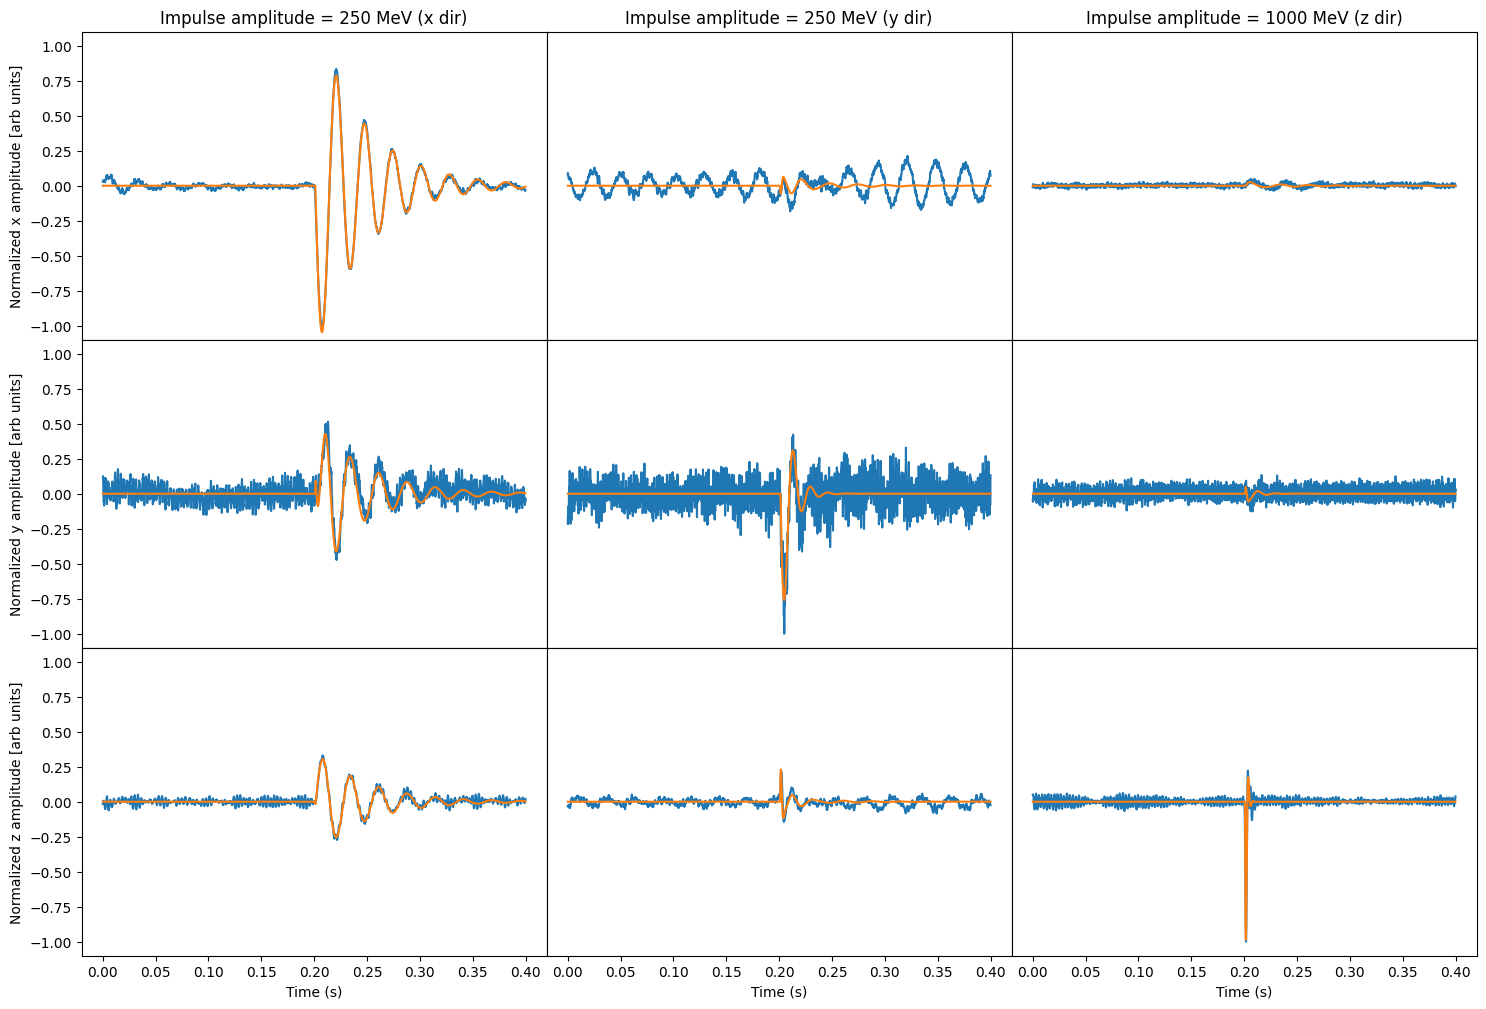

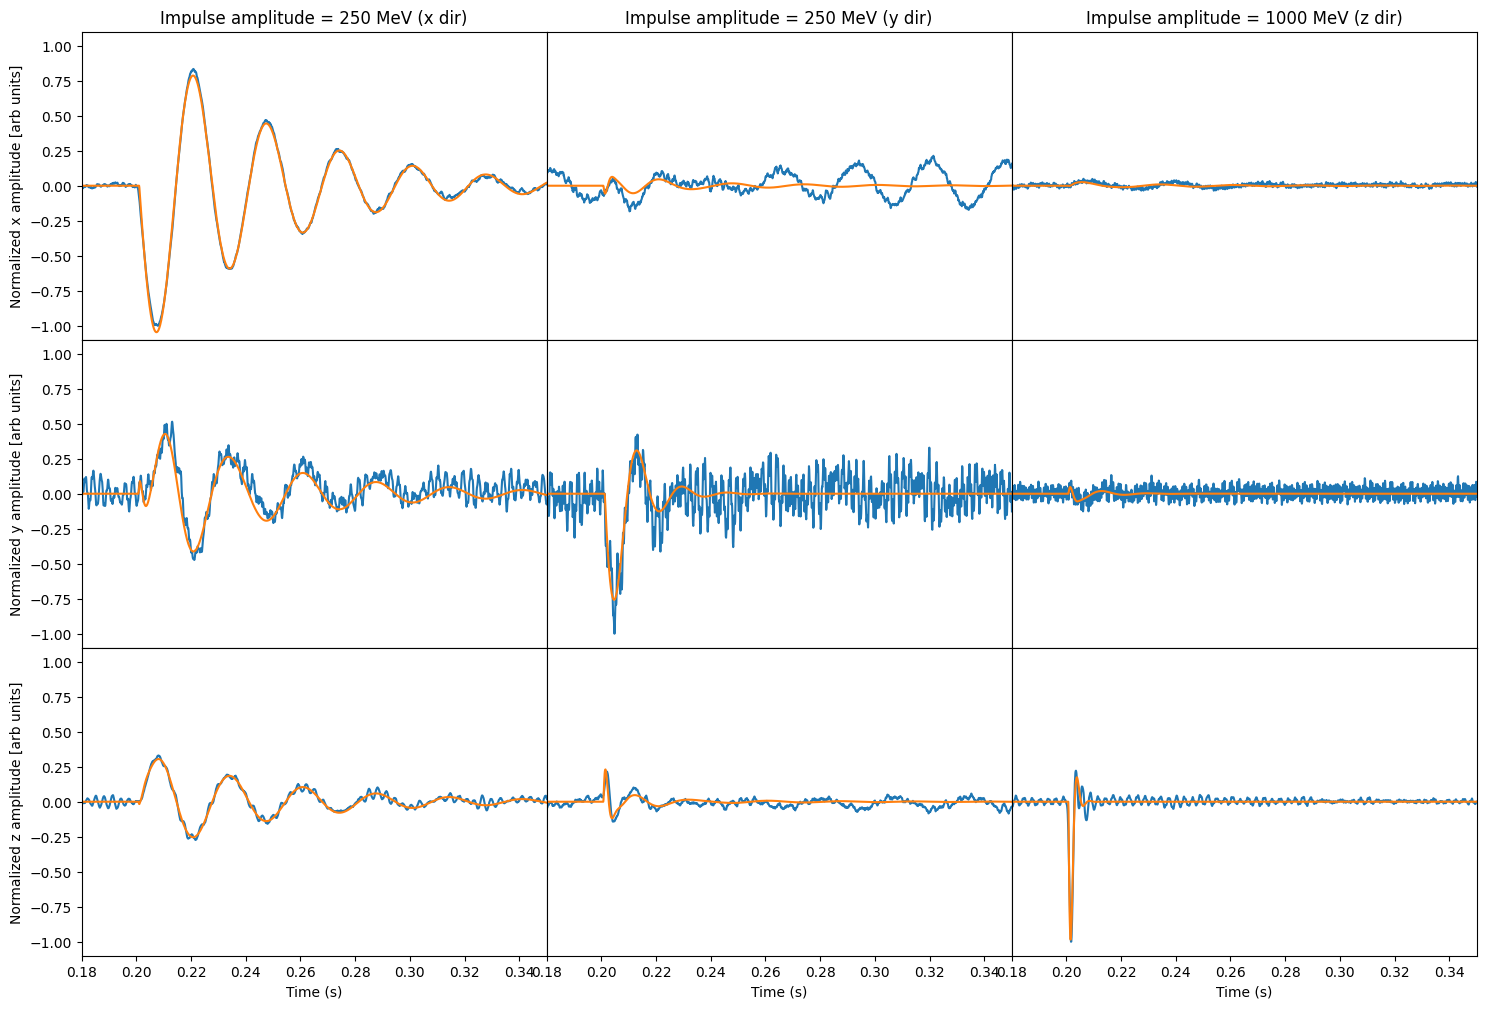

In [184]:
# calculate the pulse tempates by averaging all calibration files
importlib.reload(bu)
fit_pars_dict = {'x': [-1,2*np.pi*30,10,0.20],
                 'y': [-1,2*np.pi*70,10,0.20],
                 'z': [-1,2*np.pi*120,30,0.20]}
template_dict, template_dict_fit, fit_vals, norm_dict = bu.get_average_template_3D(calib_file_dict, make_plots=True,
                                                                        fit_pars=fit_pars_dict, drive_idx=10)
plt.savefig(plots_dir+"/template_fits_%s.png"%file_label, dpi=300, bbox_inches="tight")

## plot with smaller x range
_, _, _, _ = bu.get_average_template_3D(calib_file_dict, make_plots=True, fit_pars=fit_pars_dict, 
                                     drive_idx=10, xrange=[0.18, 0.35])
plt.savefig(plots_dir+"/template_fits_zoom_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [185]:
template_fit_vals = fit_vals
coord_list = ['x', 'y', 'z']
print("Coord\tf_0 [Hz]\tgamma/(2pi) [Hz]")
for coord in coord_list:
    fp = fit_vals[coord][coord]
    print("%s\t%.1f\t\t%.1f"%(coord, fp[1]/(2*np.pi), fp[2]/(2*np.pi)))

Coord	f_0 [Hz]	gamma/(2pi) [Hz]
x	37.4		3.4
y	60.7		17.3
z	218.4		120.5


In [186]:
## using the above, we can calibrate into volts per meters
volts_per_meters = {}
MeV_to_kgms = 5.34e-22 ## 1 MeV in kg*m/s
msphere = 2.5e-14 ## 3 um sphere @ 1.8 g/cm^3 in kg
for coord in coord_list:
    fp = fit_vals[coord][coord]
    omega0, gam = fp[1], fp[2]
    omega1 = np.sqrt( omega0**2 - gam**2 )
    t = np.linspace(0, 10/(omega0/(2*np.pi)), 1000) ## 10 periods
    p0 = norm_dict[coord + "_amp"] * MeV_to_kgms
    volts_per_meters[coord] = norm_dict[coord]/(p0*np.max(np.exp(-gam*t)*np.sin(omega1*t))/(msphere*omega1))
    #print(volts_per_meters[coord])
    print("Max motion for 250 MeV [nm]: ", p0*np.max(np.exp(-gam*t)*np.sin(omega1*t))/(msphere*omega1)*1e9)

Max motion for 250 MeV [nm]:  19.858541802441817
Max motion for 250 MeV [nm]:  9.56713971772173
Max motion for 250 MeV [nm]:  8.103297327031722


In [187]:
def clean_axes(arr):
    plt.gca().set_xticks([0,1,2])
    plt.gca().set_yticks([0,1,2])
    plt.gca().set_xticklabels(['x', 'y', 'z'])
    plt.gca().set_yticklabels(['x', 'y', 'z'])
    plt.xlabel("Drive direction")
    plt.ylabel("Response direction")
    plt.colorbar(label="Normalized amplitude")

    for i in range(np.shape(arr)[0]):
        for j in range(np.shape(arr)[1]):
            if(arr[i,j]>0.9):
                plt.text(j,i,"%.1f"%arr[i,j],color='white',ha='center',va='center')
            else:
                plt.text(j,i,"%.1f"%arr[i,j],color='k',ha='center',va='center')
    

[[ 1.         -0.11187445  0.00263857]
 [-0.4416967   1.         -0.05403691]
 [-0.3126222   0.12508778  1.        ]]


/var/folders/35/ft5fljg94_x6xpzhzn_wtctr0000gn/T/ipykernel_56704/3694904443.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  force_arr[k, j] = fit_vals[drive_coord][resp_coord][other_coord]


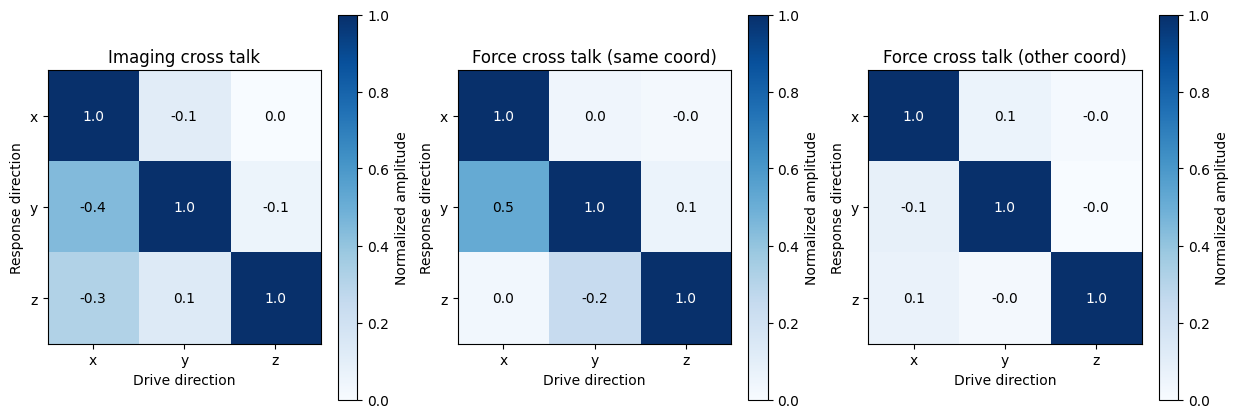

In [188]:
## now make a plot of the cross talk (separately for force and for imaging for each)
plt.figure(figsize=(15, 5))

## imaging crosstalk
xtalk_arr = np.zeros((len(coord_list), len(coord_list)))
plt.subplot(1,3,1)
for j, drive_coord in enumerate(coord_list):
    for k, resp_coord in enumerate(coord_list):
        if(j == k): 
            xtalk_arr[k, j] = 1
        else:
            xtalk_arr[k, j] = fit_vals[drive_coord][resp_coord][j]

print(xtalk_arr)
plt.imshow(np.abs(xtalk_arr), vmin=0, vmax=1, cmap='Blues')
clean_axes(xtalk_arr)
plt.title("Imaging cross talk")

## force crosstalk
force_arr = np.zeros((len(coord_list), len(coord_list)))
plt.subplot(1,3,2)
for j, drive_coord in enumerate(coord_list):
    for k, resp_coord in enumerate(coord_list):
        if(j == k): 
            force_arr[k, j] = 1
        else:
            force_arr[k, j] = fit_vals[drive_coord][resp_coord][k]

plt.imshow(np.abs(force_arr), vmin=0, vmax=1, cmap="Blues")
clean_axes(force_arr)
plt.title("Force cross talk (same coord)")

## force crosstalk (other coord)
force_arr = np.zeros((len(coord_list), len(coord_list)))
plt.subplot(1,3,3)
for j, drive_coord in enumerate(coord_list):
    for k, resp_coord in enumerate(coord_list):
        if(j == k): 
            force_arr[k, j] = 1
        else:
            other_coord = [0,1,2]
            other_coord.remove(k)
            other_coord.remove(j)
            force_arr[k, j] = fit_vals[drive_coord][resp_coord][other_coord]

plt.imshow(np.abs(force_arr), vmin=0, vmax=1, cmap="Blues")
clean_axes(force_arr)
plt.title("Force cross talk (other coord)")
plt.savefig(plots_dir+"/cross_talk_mats_%s.png"%file_label, dpi=300, bbox_inches="tight")

249
484
1432


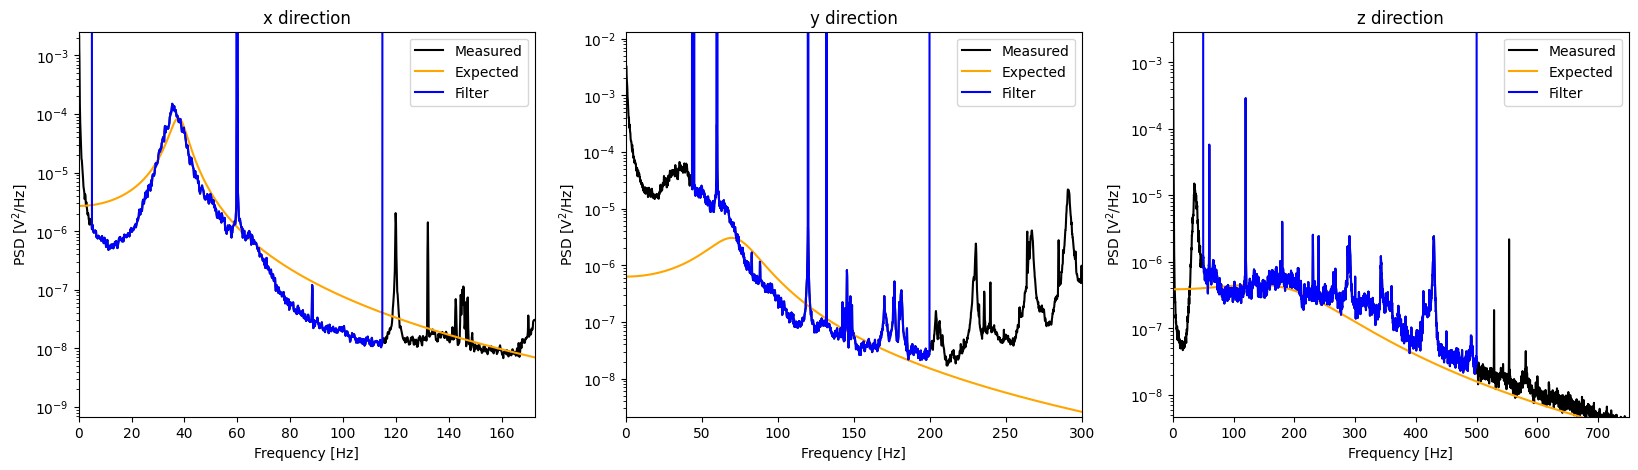

In [189]:
remake_files = True

if(remake_files):
    importlib.reload(bu)

    ## was 115
    range_dict = {'x': [5,115], 'y': [5,200], 'z': [50, 500]}

    noise_dict_3D = bu.get_noise_template_3D(noise_file_list, fit_vals, range_dict, nfft=2**16)

    plt.savefig(plots_dir+"/noise_3D_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [190]:
importlib.reload(bu)
opt_filt_amps, phi_t = bu.optimal_filt(calib_file_dict['x'], {250.0: template_dict_fit['x']['x']}, noise_dict_3D['x'], time_offset=-12, drive_idx=10, cal_fac=288.5, make_plots=False)
time_corr_amps = bu.correlation_filt(calib_file_dict['x'], {250.0: template_dict_fit['x']['x']}, bandpass=[5,70], notch_list = [], drive_idx=10, make_plots=False)
bandpass_amps = bu.bandpass_filt(calib_file_dict['x'], {250.0: template_dict_fit['x']['x']}, time_offset=0, bandpass=[5,70], drive_idx=10, cal_fac = 7550, make_plots=False)

/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis/bead_utils.py:1112: RuntimeWarning: invalid value encountered in sqrt
  corr_data = np.sqrt(sp.filtfilt(bcorr, acorr, corr_data**2))


In [191]:
importlib.reload(bu)
## calculate pedestal with search bias by time offset away from pulse
opt_filt_pedestal, _ = bu.optimal_filt(calib_file_dict['x'], {250.0: template_dict_fit['x']['x']}, noise_dict_3D['x'], time_offset=2000, drive_idx=10, cal_fac=288.5, make_plots=False)
bandpass_pedestal = bu.bandpass_filt(calib_file_dict['x'], {250.0: template_dict_fit['x']['x']}, time_offset=-500, bandpass=[5,70], drive_idx=10, cal_fac = 7550, make_plots=False)

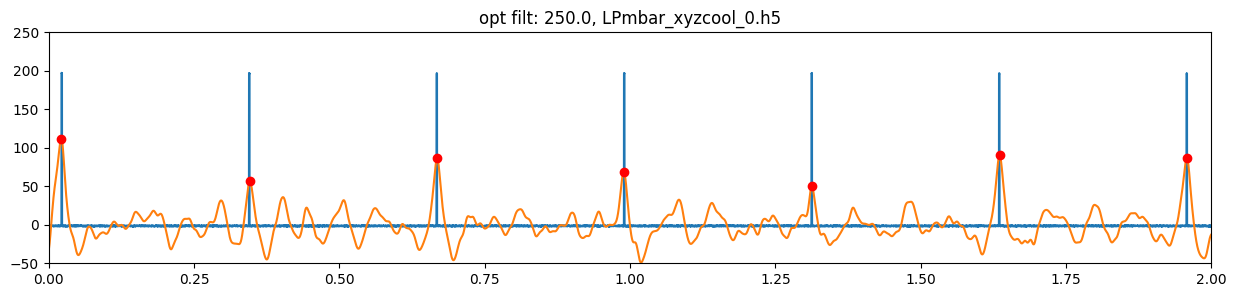

In [192]:
search_wind = 100 # +/-10 ms search

importlib.reload(bu)
opt_filt_amps_1D = bu.optimal_filt_1D(calib_file_dict, template_dict_fit, noise_dict_3D, time_offset=0, do_lp_filt=True,
                   drive_idx=10, cal_fac=2200*4.2e-8, make_plots=True, coord='x', wind=search_wind) 
opt_filt_amps_1D_y = bu.optimal_filt_1D(calib_file_dict, template_dict_fit, noise_dict_3D, time_offset=8, do_lp_filt=True,
                   drive_idx=10, cal_fac=1.5e-7*500, wind=search_wind, make_plots=False, coord='y') 
opt_filt_amps_1D_z = bu.optimal_filt_1D(calib_file_dict, template_dict_fit, noise_dict_3D, time_offset=8, do_lp_filt=True,
                        drive_idx=10, cal_fac=1.5e-7*100, wind=search_wind, make_plots=False, coord='z') 

In [193]:
importlib.reload(bu)
time_corr_amps_ped = bu.correlation_filt(calib_file_dict['x'], {250.0: template_dict_fit['x']['x']}, time_offset=2000, bandpass=[5,70], notch_list = [], drive_idx=10, wind=search_wind, make_plots=False)
bandpass_amps_ped = bu.bandpass_filt(calib_file_dict['x'], {250.0: template_dict_fit['x']['x']}, time_offset=2000, bandpass=[5,70], drive_idx=10, cal_fac = 7550, wind=search_wind, make_plots=False)
opt_filt_amps_1D_ped = bu.optimal_filt_1D(calib_file_dict, template_dict_fit, noise_dict_3D, time_offset=2000, do_lp_filt=True,
                        drive_idx=10, cal_fac=2200*4.2e-8, make_plots=False, coord='x', wind=search_wind) 
opt_filt_amps_1D_y_ped = bu.optimal_filt_1D(calib_file_dict, template_dict_fit, noise_dict_3D, time_offset=2000, do_lp_filt=True,
                   drive_idx=10, cal_fac=1.5e-7, wind=search_wind, make_plots=False, coord='y') 
opt_filt_amps_1D_z_ped = bu.optimal_filt_1D(calib_file_dict, template_dict_fit, noise_dict_3D, time_offset=2000, do_lp_filt=True,
                        drive_idx=10, cal_fac=1.5e-7*100, wind=search_wind, make_plots=False, coord='z') 

In [194]:
importlib.reload(bu)
opt_filt_amps_3D = bu.optimal_filt_3D(calib_file_dict, template_dict_fit, noise_dict_3D, time_offset=8, 
                drive_idx=10, make_plots=False, noise_scale=[1,0.167,0.167])

opt_filt_amps_3D_ped = bu.optimal_filt_3D(calib_file_dict, template_dict_fit, noise_dict_3D, time_offset=2000, 
                drive_idx=10, make_plots=False, noise_scale=[1,0.167,1e10])

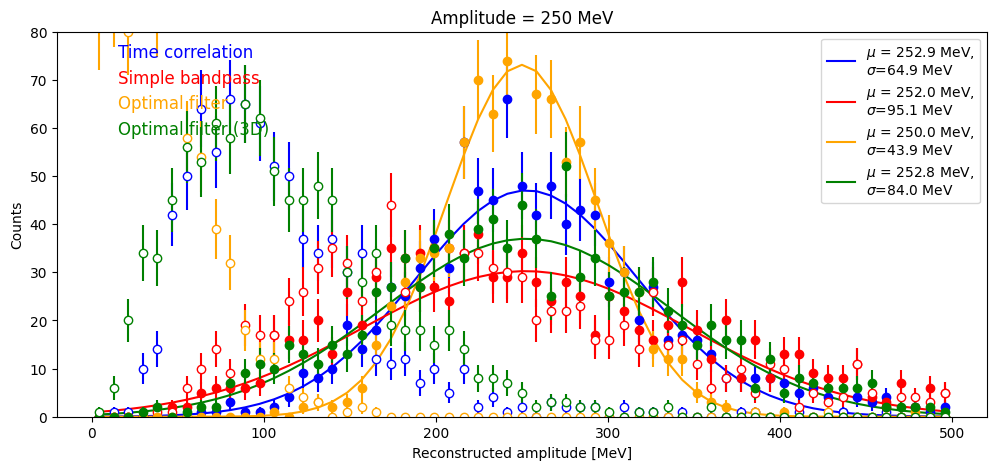

In [195]:
## compare various recon methods
amp_bins = np.arange(0,100,1.5)

def gauss_fun(x,A,mu,sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

fit_vals_amps_orig = []

amp_dicts = [time_corr_amps, bandpass_amps, opt_filt_amps_1D, opt_filt_amps_3D['x']] #, opt_filt_amps_1D_lp_filt]
ped_dicts = [time_corr_amps_ped, bandpass_amps_ped, opt_filt_amps_1D_ped, opt_filt_amps_3D_ped['x']] #, opt_filt_amps_1D_lp_filt
amp_methods = ["Time correlation", "Simple bandpass", "Optimal filter", "Optimal filter (3D)"]
amp_cal_facs = [106.8, 6889, 1.057e-5, 1.057e-5, 1.057e-5, 1.057e-5] ## set by hand to match the calibration data  ##91.2, 
amp_colors = ['b', 'r', 'orange', 'g', 'purple']

ymax = 80

plt.figure(figsize=(12,5))    
for i,filt_amps in enumerate(amp_dicts):

    for j,amp in enumerate(filt_amps.keys()):
        if( not isinstance(amp, numbers.Number)): continue
        amp_bins = np.linspace(0,2*amp,60)
        ca = filt_amps[amp]*amp_cal_facs[i]
        gpts = (ca>0)
        amp_scale = amp/np.median(ca[gpts])
        hh,be = np.histogram(ca*amp_scale, bins=amp_bins)
        bc = be[:-1] + np.diff(be)/2

        ## gauss fit
        err = np.sqrt(hh)
        err[err==0] = 1
        gp, gcov = opt.curve_fit(gauss_fun, bc, hh, sigma=err, p0=[1, amp, 50])

        ## amplitude, mean, mean_err, sig, sig_err
        fit_vals_amps_orig.append([amp, gp[1], np.sqrt(gcov[1,1]), np.abs(gp[2]), np.sqrt(gcov[2,2]), i])

        #plt.subplot(3,3,j+1)
        plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color=amp_colors[i])
        plt.plot(bc, gauss_fun(bc, *gp), amp_colors[i], label="$\mu$ = %.1f MeV,\n$\sigma$=%.1f MeV"%(gp[1], gp[2]))
        plt.title("Amplitude = %d MeV"%amp)
        plt.ylabel("Counts")
        plt.xlabel("Reconstructed amplitude [MeV]")

        if(len(ped_dicts[i]) > 0):
            ca = ped_dicts[i][amp]*amp_cal_facs[i]*amp_scale
            hh,be = np.histogram(ca, bins=amp_bins)
            bc = be[:-1] + np.diff(be)/2
            plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color=amp_colors[i], mfc='white')

        plt.text(15, ymax-(ymax/15)*(i+1), amp_methods[i], fontsize=12, color=amp_colors[i])

        #plt.suptitle(amp_methods[i])
        plt.legend()

    plt.ylim(0,ymax)
    plt.savefig(plots_dir+"/calib_reconstructed_amplitudes_%s.png"%file_label, dpi=300)

In [196]:
# fit_vals_offset = []

# ymax = 200

# plt.figure(figsize=(6,5))    
# for i,filt_amps in enumerate(amp_dicts):

#     for j,amp in enumerate(filt_amps.keys()):
#         if( isinstance(amp, numbers.Number)): continue
#         amp_val = float(amp.split("_")[0])

#         cent_time = np.median(filt_amps[amp])
#         offset_bins = np.arange(cent_time-100,cent_time + 100,2) 

#         hh,be = np.histogram(filt_amps[amp], bins=offset_bins)
#         bc = be[:-1] + np.diff(be)/2

#         ## gauss fit
#         err = np.sqrt(hh)
#         err[err==0] = 1
#         gp, gcov = opt.curve_fit(gauss_fun, bc, hh, sigma=err, p0=[1, np.median(filt_amps[amp]), np.std(filt_amps[amp])])

#         ## amplitude, mean, mean_err, sig, sig_err
#         fit_vals_offset.append([amp, gp[1], np.sqrt(gcov[1,1]), np.abs(gp[2]), np.sqrt(gcov[2,2]), i])

#         #plt.subplot(3,3,j+1)
#         plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color=amp_colors[i])
#         plt.plot(bc, gauss_fun(bc, *gp), amp_colors[i], label="$\mu$ = %.1f ADC,\n$\sigma$=%.1f ADC"%(gp[1], gp[2]))
#         plt.title("Time offset, Amplitude = %d MeV"%amp_val)
#         plt.ylabel("Counts")
#         plt.xlabel("Reconstructed time offset [ADC bins = 0.1 ms]")
#         plt.ylim(0,ymax)

#         plt.text(-90, ymax-10*(i+1), amp_methods[i], fontsize=12, color=amp_colors[i])

#         plt.legend()

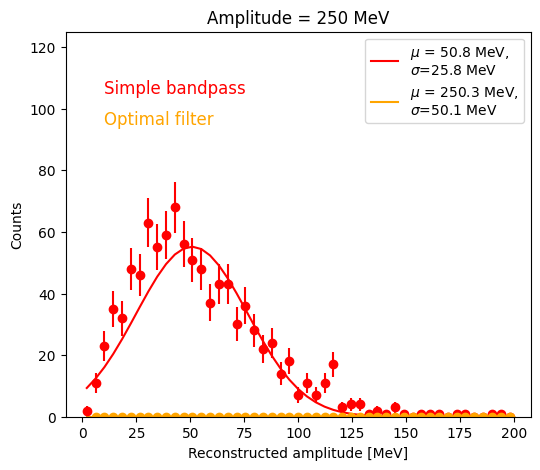

In [197]:
### now pedestal for band pass, opt filt
amp_dicts = [{}, bandpass_pedestal, opt_filt_pedestal]
amp_colors = [_, 'r', 'orange']

ymax = 125

plt.figure(figsize=(6,5))    
for i,filt_amps in enumerate(amp_dicts):
    
    for j,amp in enumerate(filt_amps.keys()):

        if( not isinstance(amp, numbers.Number)): continue
        amp_bins = np.linspace(0,200,50)
        hh,be = np.histogram(filt_amps[amp]*amp_cal_facs[i], bins=amp_bins)
        bc = be[:-1] + np.diff(be)/2

        ## gauss fit
        err = np.sqrt(hh)
        err[err==0] = 1
        gp, gcov = opt.curve_fit(gauss_fun, bc, hh, sigma=err, p0=[1, amp, 50])

        #plt.subplot(3,3,j+1)
        plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color=amp_colors[i])
        plt.plot(bc, gauss_fun(bc, *gp), amp_colors[i], label="$\mu$ = %.1f MeV,\n$\sigma$=%.1f MeV"%(gp[1], gp[2]))
        plt.title("Amplitude = %d MeV"%amp)
        plt.ylabel("Counts")
        plt.xlabel("Reconstructed amplitude [MeV]")

        plt.text(10, ymax-10*(i+1), amp_methods[i], fontsize=12, color=amp_colors[i])

        #plt.suptitle(amp_methods[i])
        plt.legend()

    plt.ylim(0,ymax)
    plt.savefig(plots_dir+"/calib_pedestal_%s.png"%file_label, dpi=300)

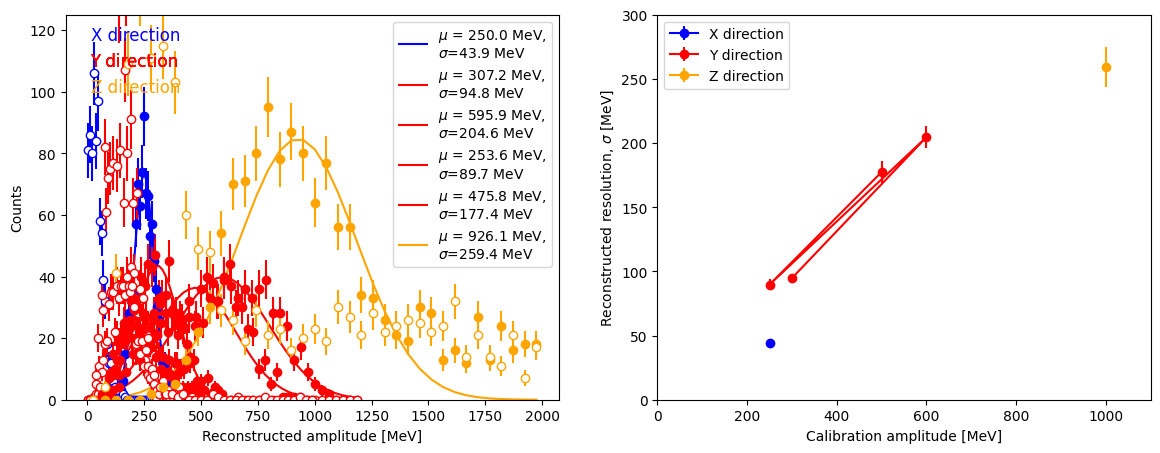

In [198]:
## compare optimal filter in each coordinate
amp_bins = np.arange(0,100,1.5)

def gauss_fun(x,A,mu,sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

fit_vals_xyz = []
sig_dict_xyz = {}

amp_dicts = [opt_filt_amps_1D, opt_filt_amps_1D_y, opt_filt_amps_1D_z]
ped_dicts = [opt_filt_amps_1D_ped, opt_filt_amps_1D_y_ped, opt_filt_amps_1D_z_ped]
amp_methods = ["X direction", "Y direction", "Z direction"]
amp_cal_facs = [1.057e-5, 3.76e-5, 4.71e-5] ## set by hand to match the calibration data
amp_colors = ['b', 'r', 'orange', 'g']

ymax = 125

calibrated_OF_amps_from_fit = np.zeros(3)

coord_list = ['x', 'y', 'z']

plt.figure(figsize=(14,5))    
for i,filt_amps in enumerate(amp_dicts):

    for j,amp in enumerate(filt_amps.keys()):
        if( not isinstance(amp, numbers.Number)): continue
        if(amp == 250):
            amp_bins = np.linspace(0,2*amp,60)
        else:
            amp_bins = np.linspace(0,2*amp,40)

        ca = filt_amps[amp]*amp_cal_facs[i]
        amp_scale = amp/np.median(ca[ca>0])
        calibrated_OF_amps_from_fit[i] = amp_scale*amp_cal_facs[i]
        hh,be = np.histogram(ca*amp_scale, bins=amp_bins)
        bc = be[:-1] + np.diff(be)/2

        ## gauss fit
        err = np.sqrt(hh)
        err[err==0] = 1
        gp, gcov = opt.curve_fit(gauss_fun, bc, hh, sigma=err, p0=[1, amp, 50])

        ## amplitude, mean, mean_err, sig, sig_err
        fit_vals_xyz.append([amp, gp[1], np.sqrt(gcov[1,1]), np.abs(gp[2]), np.sqrt(gcov[2,2]), i])

        if(j==0):
            sig_dict_xyz[coord_list[i]] = np.abs(gp[2])

        plt.subplot(1,2,1)
        plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color=amp_colors[i])
        plt.plot(bc, gauss_fun(bc, *gp), amp_colors[i], label="$\mu$ = %.1f MeV,\n$\sigma$=%.1f MeV"%(gp[1], gp[2]))
        #plt.title("Amplitude = %d MeV"%amp)
        plt.ylabel("Counts")
        plt.xlabel("Reconstructed amplitude [MeV]")

        if(len(ped_dicts[i]) > 0):
            ca = ped_dicts[i][amp]*amp_cal_facs[i]*amp_scale
            hh,be = np.histogram(ca, bins=amp_bins)
            bc = be[:-1] + np.diff(be)/2
            plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color=amp_colors[i], mfc='white')

        plt.text(15, ymax-(ymax/15)*(i+1), amp_methods[i], fontsize=12, color=amp_colors[i])

        #plt.suptitle(amp_methods[i])
        plt.legend()

    plt.ylim(0,ymax)

#plt.xlim(0,250)

fit_vals_xyz = np.array(fit_vals_xyz)
plt.subplot(1,2,2)
for i,filt_amps in enumerate(amp_dicts):
    gpts = fit_vals_xyz[:,-1] == i
    plt.errorbar(fit_vals_xyz[gpts,0], fit_vals_xyz[gpts,3], yerr=fit_vals_xyz[gpts,4], fmt='-o', color=amp_colors[i], label=amp_methods[i])
plt.xlim(0,1100)
plt.ylim(0,300)
plt.legend(loc='upper left')
plt.xlabel("Calibration amplitude [MeV]")
plt.ylabel("Reconstructed resolution, $\sigma$ [MeV]")

plt.savefig(plots_dir+"/calib_reconstructed_dirs_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [199]:
## off diagonal elements
importlib.reload(bu)
opt_fit_1d_mat = {}
coord_list = ['x', 'y', 'z']
for dc in coord_list:
    opt_fit_1d_mat[dc] = {}
    for rc  in coord_list:
        opt_fit_1d_mat[dc][rc] = bu.optimal_filt_1D(calib_file_dict, template_dict_fit, noise_dict_3D, time_offset=8, 
                                                    drive_idx=10, cal_fac=1, make_plots=False, coord=dc, resp_coord=rc) 

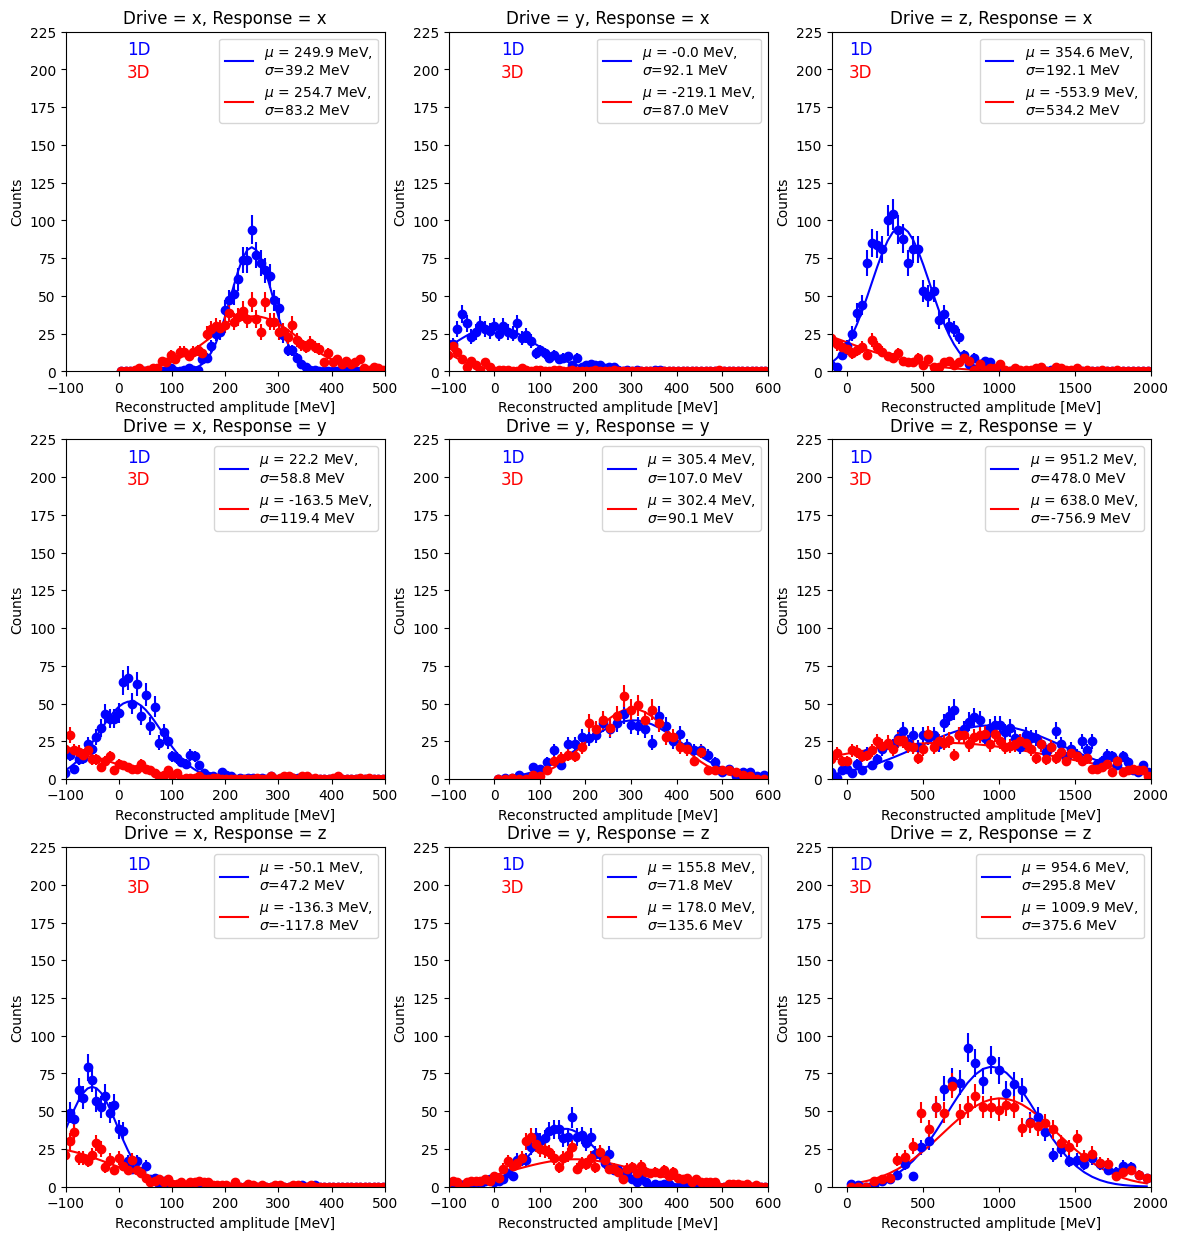

In [211]:
## compare optimal filter in each coordinate
amp_bins = np.arange(0,100,1.5)

def gauss_fun(x,A,mu,sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

fit_vals_xyz = []

coords = ['x', 'y', 'z']
amp_dicts = [opt_fit_1d_mat, opt_filt_amps_3D]
amp_methods = ["X direction", "Y direction", "Z direction"]
amp_cal_facs = [1.057e-5, 3.76e-5, 4.71e-5] ## set by hand to match the calibration data
amp_colors = ['b', 'r', 'orange', 'g']
alg_list = ['1D', '3D']

ymax = 225

plt.figure(figsize=(14,15))    
for i,coord in enumerate(coords):
    for l,resp_coord in enumerate(coords):   

        for k,alg in enumerate(alg_list):
            filt_amps = amp_dicts[k][coord][resp_coord]

            for j,amp in enumerate(filt_amps.keys()):
                if( not isinstance(amp, numbers.Number)): continue
                if(j > 0):
                    continue
                if(coord==resp_coord):
                    if(amp == 250):
                        amp_bins = np.linspace(0,2*amp,60)
                    else:
                        amp_bins = np.linspace(0,2*amp,40)
                else:
                    amp_bins = np.linspace(-2*amp,2*amp,2*60)     

                ca = filt_amps[amp]*amp_cal_facs[i]
                amp_scale = amp/np.median(amp_dicts[k][coord][coord][amp]*amp_cal_facs[i])
                hh,be = np.histogram(ca*amp_scale, bins=amp_bins)
                bc = be[:-1] + np.diff(be)/2

                ## gauss fit
                err = np.sqrt(hh)
                err[err==0] = 1
                try:
                    gp, gcov = opt.curve_fit(gauss_fun, bc, hh, sigma=err, p0=[1, np.median(ca*amp_scale), np.std(ca*amp_scale)])
                except:
                    gp = [1, np.median(ca*amp_scale), np.std(ca*amp_scale)]
                    gcov = np.ones((3,3))*np.inf

                ## amplitude, mean, mean_err, sig, sig_err
                fit_vals_xyz.append([amp, gp[1], np.sqrt(gcov[1,1]), np.abs(gp[2]), np.sqrt(gcov[2,2]), i, l, k])

                sidx = 3*l + i + 1
                plt.subplot(3,3,sidx)
                plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color=amp_colors[k])
                plt.plot(bc, gauss_fun(bc, *gp), amp_colors[k], label="$\mu$ = %.1f MeV,\n$\sigma$=%.1f MeV"%(gp[1], gp[2]))
                #plt.title("Amplitude = %d MeV"%amp)
                plt.ylabel("Counts")
                plt.xlabel("Reconstructed amplitude [MeV]")

                plt.text(15, ymax-15*(k+1), alg_list[k], fontsize=12, color=amp_colors[k])

                plt.title("Drive = %s, Response = %s"%(coords[i], coords[l]))
                plt.legend()
                plt.xlim(-100,2*amp)

            plt.ylim(0,ymax)


plt.savefig(plots_dir+"/calib_1D3D_dirs_%s.png"%file_label, dpi=300, bbox_inches="tight")
np.save(os.path.join(data_dir, "xtalk_fits_%s.npy"%file_label), fit_vals_xyz)

In [201]:
remake_files = False

if(remake_files):
    nsegs = 2**6 ## number of segments to chop up for Welch's method
    cdat, attr, fhandle = bu.get_data(data_list[0])
    nps = int(len(cdat[:,0])/nsegs)

    files_to_use = data_list
    noise_arr = np.zeros((len(files_to_use), int(nps/2)+1))
    time_arr = np.zeros(len(files_to_use))
    for i,f in enumerate(files_to_use):

        if(i%10 == 0): print("working on file %d: %s"%(i, f))
        
        cdat, attr, fhandle = bu.get_data(f)
        if(not fhandle):
            continue    

        xdata = cdat[:,0]
        cf, cpsd = sig.welch(xdata, fs=attr['Fsamp'], nperseg=nps)
        
        noise_arr[i,:] = cpsd
        time_arr[i] = attr["Time"]

    freqs = cf
    time_arr -= time_arr[0] # time since start
    time_arr /= 3600 ## convert to hours
    np.savez(os.path.join(data_dir, "noise_data_vs_time.npz"), noise_arr=noise_arr, time_arr=time_arr, freqs=freqs)
else:
    npzfile = np.load(os.path.join(data_dir, "noise_data_vs_time.npz"))
    noise_arr = npzfile['noise_arr']
    time_arr = npzfile['time_arr']
    freqs = npzfile['freqs']

In [202]:
## time of calibration
cdat, attr, fhandle = bu.get_data(calib_file_dict['x'][250.0][0])
tcal = attr["Time"]

cdat, attr, fhandle = bu.get_data(noise_file_list[-1])
tcal_end = attr["Time"]

cdat, attr, fhandle = bu.get_data(data_list[0])
tstart = attr["Time"]

cal_start = (tcal-tstart)/3600
cal_end = (tcal_end-tstart)/3600
print(cal_start, cal_end)

51.63482807623016 88.92886817349329


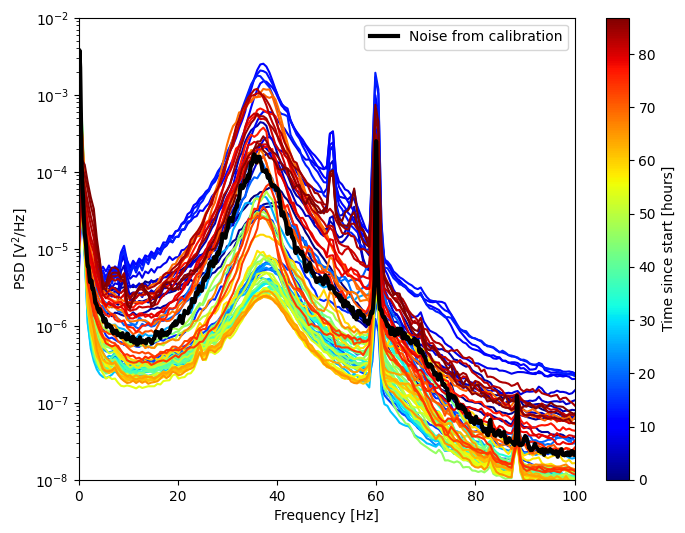

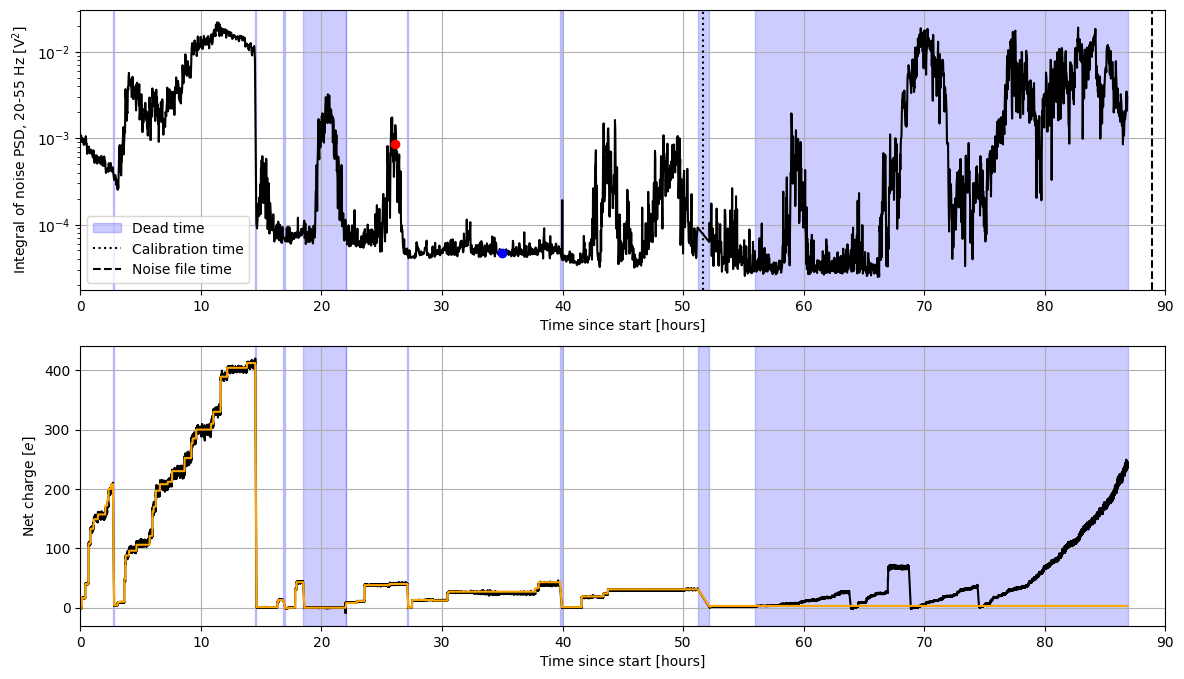

In [203]:
## make a plot of the noise vs time
plt.figure(figsize=(8,6))

nstep = 40
n = int(np.sum(time_arr>-1)/nstep)+1
cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, n)]

integ_pts_lo = (freqs>10) & (freqs<20)
integ_pts_hi = (freqs>20) & (freqs<55)

cidx = 0
noise_vs_time = []
for i in range(np.shape(noise_arr)[0]):
    #if(time_arr[i] > 55): break
    if(i%nstep == 0):
        plt.semilogy(freqs, np.median(noise_arr[i:(i+nstep),:], axis=0), color=colors[cidx])
        cidx+=1


    integ_lo = np.trapz(noise_arr[i,integ_pts_lo], x=freqs[integ_pts_lo]) 
    integ_hi = np.trapz(noise_arr[i,integ_pts_hi], x=freqs[integ_pts_hi]) 

    noise_vs_time.append([time_arr[i], integ_lo, integ_hi])
        
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=time_arr[0], vmax=time_arr[-1]))
sm.set_array([])
ax = plt.gca()
plt.colorbar(sm, ax=ax, label="Time since start [hours]")

plt.semilogy(noise_dict['freq'], noise_dict['Jorig'], 'k-', label="Noise from calibration", lw=3)

plt.legend()
plt.xlim(0,100)
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [V$^2$/Hz]")
plt.ylim(1e-8, 1e-2)

plt.savefig(plots_dir+"/noise_spec_vs_time_%s.png"%file_label, dpi=300)

noise_vs_time = np.array(noise_vs_time)

## compare file at 35 hours to one at 21 hours
bad_idx = np.argmin(np.abs(noise_vs_time[:,0]-26.1))
good_idx = np.argmin(np.abs(noise_vs_time[:,0]-35))

plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
#plt.semilogy(noise_vs_time[:,0], noise_vs_time[:,1], 'b')
plt.semilogy(noise_vs_time[:,0], noise_vs_time[:,2], 'k')
plt.semilogy(noise_vs_time[bad_idx,0], noise_vs_time[bad_idx,2], 'ro')
plt.semilogy(noise_vs_time[good_idx,0], noise_vs_time[good_idx,2], 'bo')
plt.grid(True)
fill_dps()
plt.xlim(time_hours[0], 90)
plt.xlabel("Time since start [hours]")
plt.ylabel("Integral of noise PSD, 20-55 Hz [V$^2$]")
#plt.legend(loc="upper right")
yy = plt.ylim()
plt.plot([cal_start, cal_start], yy, 'k:', label="Calibration time")
plt.plot([cal_end, cal_end], yy, 'k--', label="Noise file time")
plt.legend(loc="lower left")

plt.subplot(2,1,2)
plt.plot(time_hours[1:], corr_vec[1:,corr_idx]/cal_fac*recal, 'k-', label="Correlation")
plt.plot(time_hours[1:], running_charge, '-', color='orange', label="Recon. charge")
plt.grid(True)
fill_dps()
plt.xlim(time_hours[0], 90)
plt.xlabel("Time since start [hours]")
plt.ylabel("Net charge [$e$]")
#plt.legend(loc="upper right")

plt.savefig(plots_dir+"/noise_vs_time_%s.png"%file_label, dpi=300)

plt.show()

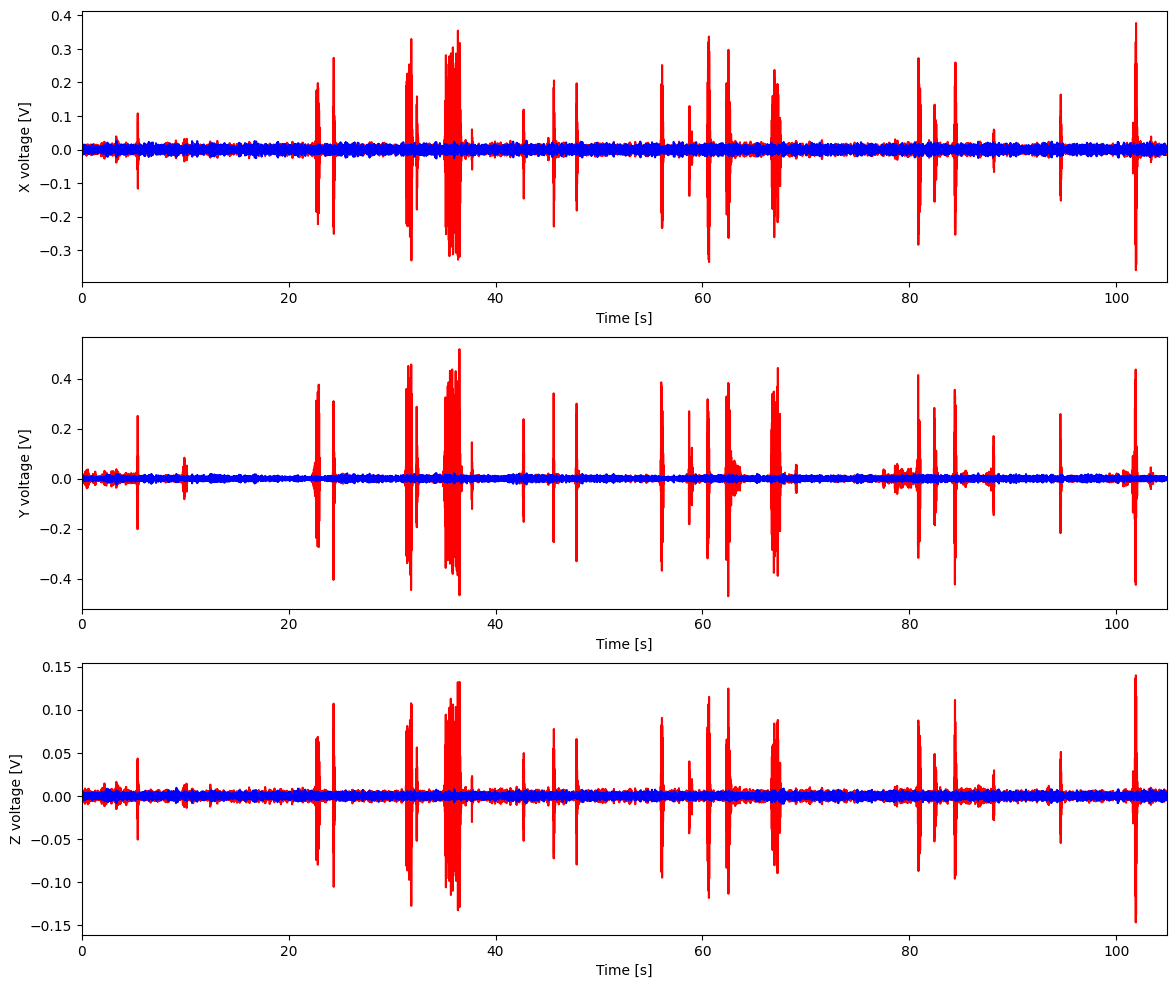

In [204]:
## compare an example "good" and "bad" file
bad_dat, attr, fhandle = bu.get_data(data_list[bad_idx])
good_dat, attr, fhandle = bu.get_data(data_list[good_idx])

plt.figure(figsize=(14,12))

fc = np.array([20, 55])/(attr['Fsamp']/2)
b,a = sig.butter(3, fc, btype='bandpass')

coord = ['X', 'Y', 'Z']
for i in range(3):
    plt.subplot(3,1,i+1)

    bd = sig.filtfilt(b,a,bad_dat[:,i])
    gd = sig.filtfilt(b,a,good_dat[:,i])

    plt.plot(tvec, bd, 'r')
    plt.plot(tvec, gd, 'b')
    plt.xlim(tvec[0], tvec[-1])
    plt.xlabel("Time [s]")
    plt.ylabel(coord[i] + " voltage [V]")

plt.savefig(plots_dir+"/noise_bursts_%s.png"%file_label, dpi=300, bbox_inches="tight")

plt.show()

In [205]:
remake_files = False


if(remake_files):

    fc = np.array([20, 55])/(attr['Fsamp']/2)
    b,a = sig.butter(3, fc, btype='bandpass')

    files_to_use = data_list
    noise_rms = np.zeros(len(files_to_use))
    time_arr = np.zeros(len(files_to_use))
    for i,f in enumerate(files_to_use):

        if(i%10 == 0): print("working on file %d: %s"%(i, f))
        
        cdat, attr, fhandle = bu.get_data(f)
        if(not fhandle):
            continue    

        xdata = cdat[:,0]
        noise_rms[i] = np.median( np.sqrt( sig.filtfilt(b,a,xdata)**2 ) )
        time_arr[i] = attr["Time"]

    time_arr -= time_arr[0] # time since start
    time_arr /= 3600 ## convert to hours
    np.savez(os.path.join(data_dir, "noise_rms_vs_time.npz"), noise_rms=noise_rms, time_arr=time_arr)
else:
    npzfile = np.load(os.path.join(data_dir, "noise_rms_vs_time.npz"))
    noise_rms = npzfile['noise_rms']
    time_arr = npzfile['time_arr']

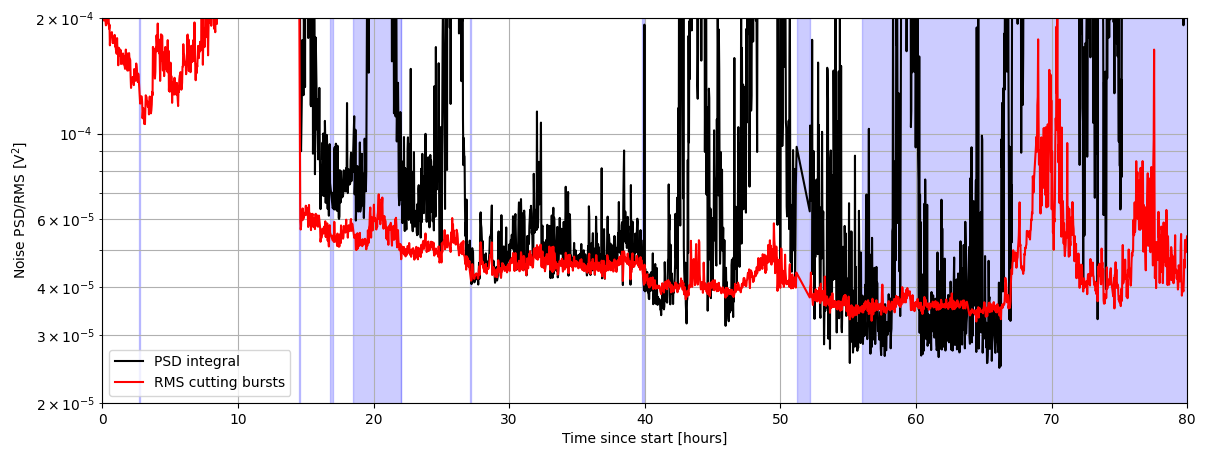

In [206]:
plt.figure(figsize=(14,5))

plt.semilogy(noise_vs_time[:,0], noise_vs_time[:,2], 'k', label="PSD integral")
plt.semilogy(time_arr, noise_rms/1e2, 'r', label="RMS cutting bursts")
plt.legend()
fill_dps()
plt.xlim(0,80)
plt.xlabel("Time since start [hours]")
plt.ylabel("Noise PSD/RMS [V$^2$]")

plt.savefig(plots_dir+"/noise_rms_vs_time_%s.png"%file_label, dpi=300, bbox_inches="tight")

plt.ylim(2e-5, 2e-4)
plt.grid(True, which='both')

plt.savefig(plots_dir+"/noise_rms_zoom_%s.png"%file_label, dpi=300, bbox_inches="tight")

plt.show()

1214
16.0
1215
16.0
1216
16.0


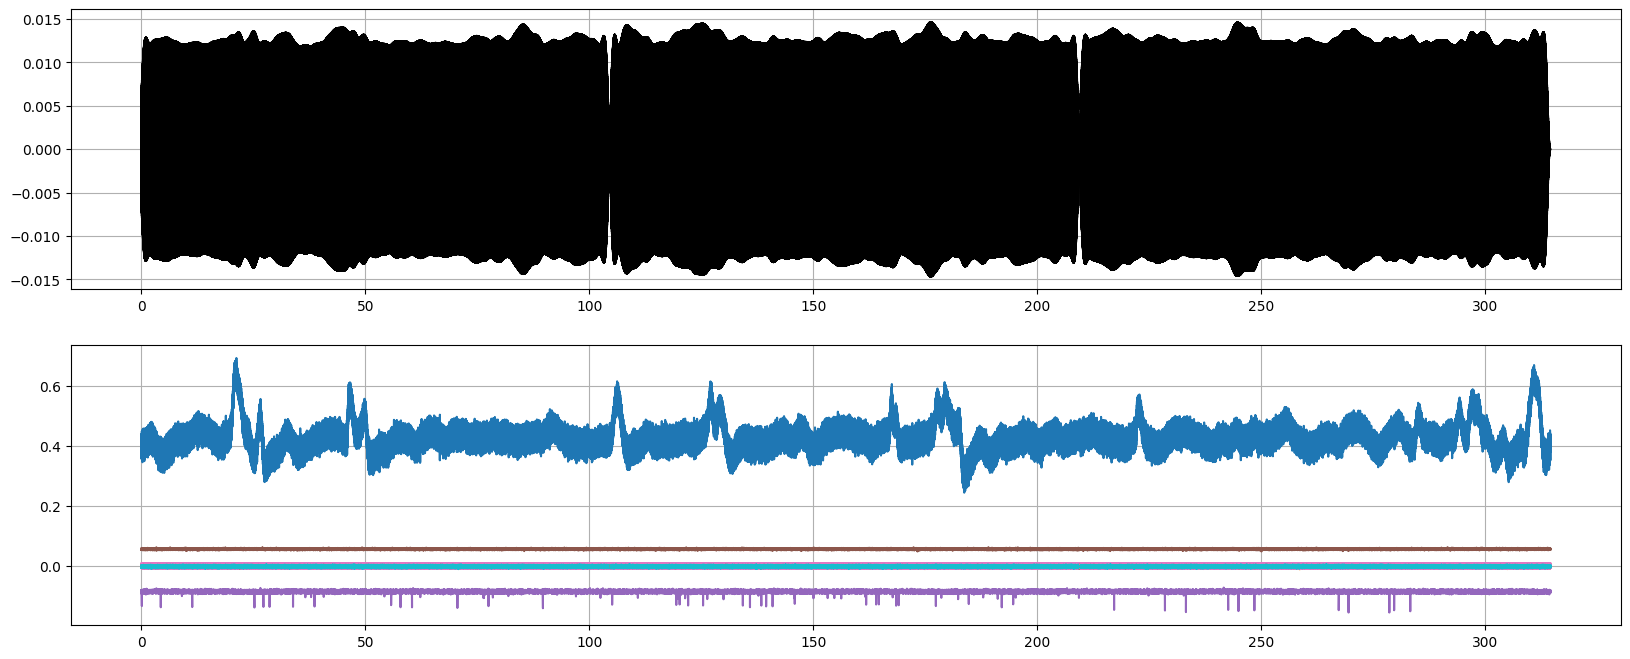

In [207]:
## code to plot individual files charge change
#cdat, attr, fhandle = bu.get_data(data_list[int(1210/16)])
idx=1214*16
nfiles = 3
plt.figure(figsize=(20,8))
for nf in range(nfiles):

    ifile = int(idx/16)+nf
    print(ifile)
    cdat, attr, fhandle = bu.get_data(data_list[ifile])  ## correlated decays 20 s apart?
    #fn = np.array([104, 117])/5000
    fn = np.array([110.5, 111.5])/5000
    b,a = sig.butter(3, fn, btype='bandpass')
    fdat = sig.filtfilt(b,a,cdat[:,0])
    print(len(fdat)/2**16)

    tvec = np.arange(0, len(fdat))/1e4 + nf*(len(fdat)-1)/1e4


    plt.subplot(2,1,1)
    plt.plot(tvec,fdat, 'k')
    plt.grid(True)

    plt.subplot(2,1,2)
    for i in range(10):
        fdat = cdat[:,2+i]
        plt.plot(tvec,fdat)
    plt.grid(True)

    #plt.xlim(50,58)
    #plt.ylim(0.06, 0.10)

#plt.figure()
#f,p = sig.welch(cdat[:,0], fs=1e4,nperseg=2**16)
#plt.semilogy(f,p)
#plt.xlim(100,120)

In [208]:
#idx_of_charge_changes = np.where(changes)[0]
#good_changes = np.diff(idx_of_charge_changes) > 0
#good_changes = np.hstack((good_changes,[True])) ## add the last one
#idx_of_charge_changes = idx_of_charge_changes[good_changes]

idx_of_charge_changes = []
change_times = good_change_list[:,0]
for ct in change_times:
    idx_of_charge_changes.append(np.argmin(np.abs(time_hours[:-1]-ct)))

file_idx_of_charge_changes = np.array(idx_of_charge_changes)/num_pts_per_file
#for i in file_idx_of_charge_changes:
#    print("%d, 0"%i)


In [209]:
## charge calibration factors
recal_fac = 170.5/np.median(corr_vec[:,3]) ## relative to 30 mV
cal_fac_fine, cal_fac_coarse = 6126.7*recal_fac**2, 47.57*recal_fac**2 ## factor of 4 for (30 mV/15 mV)^2

## roll to the average difference in max times
filt_bins_offset = int(fit_vals_offset[0][1]-fit_vals_offset[1][1])

working on file:  3
working on file:  4
working on file:  5
working on file:  13
working on file:  14
working on file:  22
working on file:  28
working on file:  36
working on file:  38
working on file:  49
working on file:  70
working on file:  75
working on file:  79
working on file:  86
working on file:  101
working on file:  103
working on file:  120
working on file:  123
working on file:  124
working on file:  134
working on file:  154
working on file:  192
working on file:  199
working on file:  203
working on file:  209
working on file:  221
working on file:  242
working on file:  255
working on file:  290
working on file:  309
working on file:  313
working on file:  323
working on file:  365
working on file:  371
working on file:  392
working on file:  410
working on file:  466
working on file:  549
working on file:  552
working on file:  573
working on file:  594


KeyboardInterrupt: 

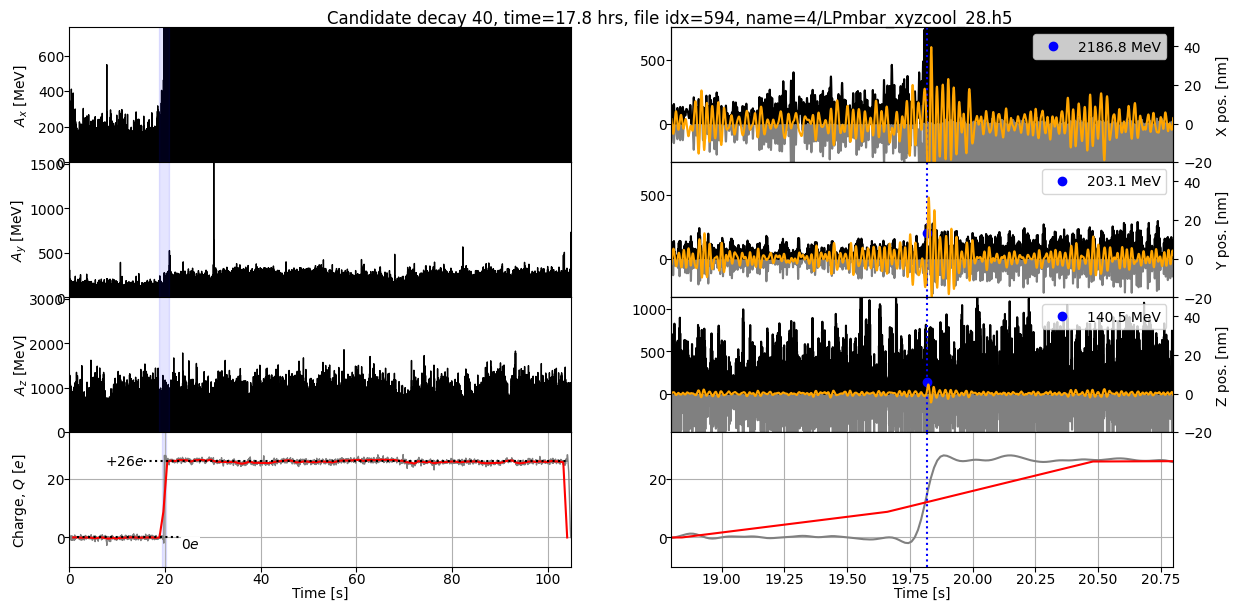

In [210]:
## now assemble a list of the candidate decays and use the recon methods above to look for pulses
remake_files = False
importlib.reload(bu)

idx_to_use = [0,1,2]
step_times = np.loadtxt(os.path.join(data_dir, "step_times_%s.txt"%file_label), delimiter=',')
xwind = 5
cwind = 0.5

step_subtract = False
do_subtract_plots = False

plot_prepulse = False

save_png = [] #2, 32, 41]

max_files_per_pdf = 100
pdf_idx = 0

if(step_subtract):  
    step_label = "step_sub"
else:
    step_label = "no_sub"

fname = data_dir+"/pulse_recon_%s_%s.pkl"%(step_label, file_label)

if(remake_files):

    curr_plots_dir = os.path.join(plots_dir, "pulses")
    if(not os.path.isdir(curr_plots_dir)):
        os.makedirs(curr_plots_dir)

    pulse_data = {}
    fig = plt.figure(figsize=(12,6))

    if(step_subtract and do_subtract_plots):
        fig_sub = plt.figure(figsize=(12,8))
    else:
        fig_sub = None

    if(plot_prepulse):
        fig_prepulse = plt.figure(figsize=(12,8))
    else:
        fig_prepulse = None     

    for j,idx in enumerate(np.unique(np.floor(file_idx_of_charge_changes))):
    
        print("working on file: ", int(idx))
        #if(j<19): continue
        #if(j>37): break
        #if(idx < 400): continue
        step_idx = np.floor(step_times[:,0]).astype(int).tolist().index(int(idx))
        step_time = step_times[step_idx,1]

        #if(idx != 1218): continue

        if(step_time < 0): continue

        cfile = data_list[int(idx)]
        cdat, attr, _ = bu.get_data(cfile)
        omega0, gamma = fit_vals['x']['x'][1], fit_vals['x']['x'][2]

        if(step_time > 0):
            xrange=[step_time-xwind,step_time+xwind]
            charge_range=[step_time-cwind,step_time+cwind]
        else:
            xrange, charge_range = [-1, -1], [-1, -1]

        curr_step_params = bu.plot_impulse_with_recon_3D(cdat, attr, template_dict_fit, noise_dict_3D, cal_facs=[cal_fac_fine, cal_fac_coarse], 
                                                    amp_cal_facs=[volts_per_meters, calibrated_OF_amps_from_fit], ylim_init=[0,200],
                                                    filt_time_offset = filt_bins_offset, drive_idx=8, figout=fig, do_lowpass=False, 
                                                    xrange=xrange, charge_range=charge_range, rasterized=True, res_pars=[omega0, gamma],
                                                    filt_charge_data=True, field_cal_fac=0.8, ylim2_scale=4.75, plot_wind_zoom=1,
                                                    ylim_nm=[-20,50], ylim_nm_z=[-20,50], charge_wind=10, plot_peak=True,
                                                    subtract_sine_step=step_subtract, do_subtract_plots=do_subtract_plots, figsub=fig_sub,
                                                    fit_prepulse=plot_prepulse, prepulse_fig=fig_prepulse, search_wind=0.05 )
        


        plt.figure(fig.number)
        file_parts = '/'.join(cfile.split("/")[-2:])
        ctime = (attr['Time']-corr_vec[0,-1])/3600
        plt.suptitle("Candidate decay %d, time=%.1f hrs, file idx=%d, name=%s"%(j, ctime, int(idx), file_parts))
        curr_step_params['time_hours'] = ctime
        curr_step_params['filename'] = cfile
        pulse_data[idx] = curr_step_params

        if(idx in save_png):
            plt.savefig(curr_plots_dir+"/candidate_decay_%s_%s_%d.png"%(file_label, step_label, idx), dpi=150, bbox_inches="tight")

        plt.savefig(curr_plots_dir+"/candidate_decay_%s_%s_%d.pdf"%(file_label, step_label, idx), dpi=150, bbox_inches="tight")
        fig.clf()

        if(step_subtract and do_subtract_plots):
            plt.figure(fig_sub.number)
            plt.suptitle("Candidate decay %d, time=%.1f hrs, file idx=%d, name=%s"%(j, ctime, int(idx), file_parts))
            plt.savefig(curr_plots_dir+"/step_sub_%s_%s_%d.pdf"%(file_label, step_label, idx), dpi=150, bbox_inches="tight")
            fig_sub.clf()

        if(plot_prepulse):
            plt.figure(fig_prepulse.number)
            plt.suptitle("Candidate decay %d, time=%.1f hrs, file idx=%d, name=%s"%(j, ctime, int(idx), file_parts))
            plt.savefig(curr_plots_dir+"/prepulse_%s_%s_%d.pdf"%(file_label, step_label, idx), dpi=150, bbox_inches="tight")
            fig_prepulse.clf()

    plt.close(fig)
    plt.close(fig_sub)
    plt.close(fig_prepulse)

    with open(fname, 'wb') as fout:
        pickle.dump(pulse_data, fout)
else:
    
    with open(fname, 'rb') as fin:
        pulse_data = pickle.load(fin)


In [ ]:
remake_files=True

fname_nosub = data_dir+"/pulse_recon_no_sub_%s.pkl"%(file_label)
with open(fname_nosub, 'rb') as fin:
    pulse_data = pickle.load(fin)

fname_refined = data_dir+"/pulse_recon_no_sub_refined_%s.pkl"%(file_label)

if(remake_files):

    pulse_data_refined = {}


    curr_plots_dir = os.path.join(plots_dir, "pulses")
    if(not os.path.isdir(curr_plots_dir)):
        os.makedirs(curr_plots_dir)

    sig_vec = [sig_dict_xyz['x'], sig_dict_xyz['y'], 1e20]

    importlib.reload(bu)
    for j,k in enumerate(pulse_data.keys()):
        #if(j != 4 ): continue
        
        idx = data_list.index(pulse_data[k]['filename'])
        print(idx)
        #if(idx != 834): continue

        step_pars, fig = bu.pulse_recon(pulse_data[k], fit_vals, template_dict=template_dict_fit, noise_dict=noise_dict_3D, 
                                        sigma=sig_vec, amp_cal_facs=[volts_per_meters, calibrated_OF_amps_from_fit], do_bandpass=True)
        plt.savefig(curr_plots_dir+"/refined_cand_decay_%s_%s_%d.png"%(file_label, step_label, idx), dpi=150, bbox_inches="tight")   

        plt.close(fig) 

        pulse_data_refined[k] = step_pars 

    with open(fname_refined, 'wb') as fout:
        pickle.dump(pulse_data_refined, fout)
        
else:
    
    with open(fname_refined, 'rb') as fin:
        pulse_data_refined = pickle.load(fin)

573
594
598
762
785
912
1264
1273
1388
1450
1721


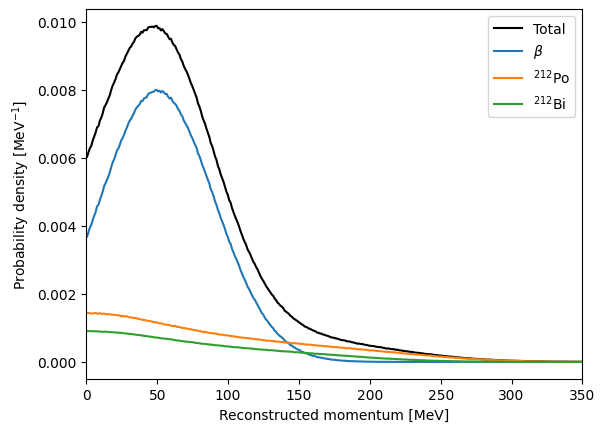

In [ ]:
## what is the expected distribution of amplitudes projected onto x:
npts = int(1e7)
phi = 2*np.pi*np.random.rand(npts)
theta = np.arccos(2*np.random.rand(npts)-1)

## beta, Po212, Bi212
decay_momenta = [0, 265, 220] ## MeV
branching_fractions = [0.58, 0.27, 0.15] ## fraction of decays
labels = [r'$\beta$', '$^{212}$Po', '$^{212}$Bi']
noise = 40 ## MeV

bins = np.linspace(0, 350, 350)
htot = np.zeros(len(bins)-1)
hlist = []
for j,dm in enumerate(decay_momenta):
    curr_vals = dm*np.sin(phi)*np.cos(theta) + np.random.randn(npts)*noise 
    if(dm == 0):
        curr_vals += 50 ## pedestal dominates for beta decays
    hh, be = np.histogram(curr_vals, bins=bins)
    hlist.append(branching_fractions[j]*hh)
    htot += branching_fractions[j]*hh

norm = np.sum(htot)
htot /= norm

bc = bins[:-1] + 0.5*np.diff(bins)

plt.figure()
plt.plot(bc, htot, 'k', label='Total')

for j,hh in enumerate(hlist):
    plt.plot(bc, hh/norm, label=labels[j])

plt.xlabel("Reconstructed momentum [MeV]")
plt.ylabel("Probability density [MeV$^{-1}$]")
plt.xlim(0,350)

exp_bins = bc
exp_pdf = htot

plt.legend()
plt.savefig(plots_dir+"/expected_spectrum_%s.png"%file_label, dpi=300, bbox_inches="tight")
plt.show()


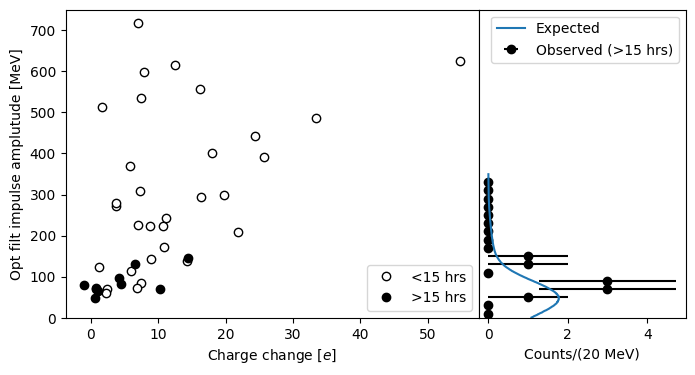

In [ ]:
## plot the reconstructed impulse amplitude versus the charge change
ymax = 750
fig, (scatter_ax, hist_ax) = plt.subplots(1, 2, figsize=(8, 4), width_ratios=[2,1])

plt.sca(scatter_ax)
plt.plot(pulse_data[:36,2], pulse_data[:36,0], 'ko', mfc='white', label="<15 hrs")
plt.plot(pulse_data[36:,2], pulse_data[36:,0], 'ko', label=">15 hrs")
xx = np.linspace(0,60)
#plt.plot(xx, 626/60*xx + 50, 'b:')
plt.ylim(0,ymax)
plt.xlabel("Charge change [$e$]")
plt.ylabel("Opt filt impulse amplutude [MeV]")
plt.legend()

hh, be = np.histogram(pulse_data[36:,0], bins=17, range=(0,340))
bc = be[:-1] + np.diff(be)/2
plt.sca(hist_ax)
hist_ax.errorbar(hh, bc, xerr=np.sqrt(hh), fmt='ko', label='Observed (>15 hrs)', zorder=0)
hist_ax.plot(exp_pdf*20*len(pulse_data[36:,0]), exp_bins, label='Expected')
plt.yticks([])
plt.ylim(0,ymax)
plt.xlabel("Counts/(20 MeV)")
plt.legend()

plt.subplots_adjust(wspace=0)


plt.savefig(plots_dir+"/amp_vs_charge_change_%s.png"%file_label, dpi=300, bbox_inches="tight")

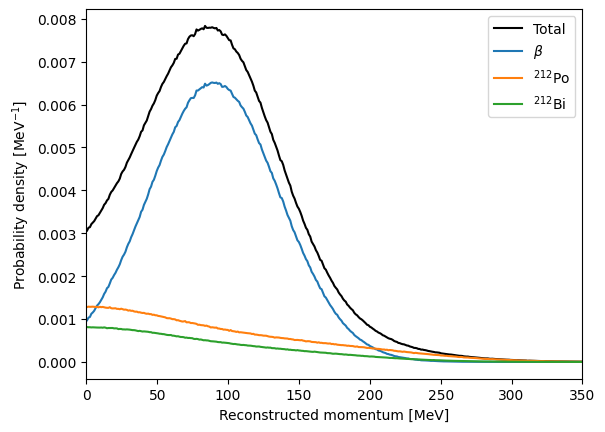

In [ ]:
### now the same for the bandpass filter #########################



## what is the expected distribution of amplitudes projected onto x:
npts = int(1e7)
phi = 2*np.pi*np.random.rand(npts)
theta = np.arccos(2*np.random.rand(npts)-1)

## beta, Po212, Bi212
decay_momenta = [0, 265, 220] ## MeV
branching_fractions = [0.58, 0.27, 0.15] ## fraction of decays
labels = [r'$\beta$', '$^{212}$Po', '$^{212}$Bi']
noise = 46 ## MeV

bins = np.linspace(0, 350, 350)
htot = np.zeros(len(bins)-1)
hlist = []
for j,dm in enumerate(decay_momenta):
    curr_vals = dm*np.sin(phi)*np.cos(theta) + np.random.randn(npts)*noise 
    if(dm == 0):
        curr_vals += 90 ## pedestal dominates for beta decays, long window (0.1s)
    hh, be = np.histogram(curr_vals, bins=bins)
    hlist.append(branching_fractions[j]*hh)
    htot += branching_fractions[j]*hh

norm = np.sum(htot)
htot /= norm

bc = bins[:-1] + 0.5*np.diff(bins)

plt.figure()
plt.plot(bc, htot, 'k', label='Total')

for j,hh in enumerate(hlist):
    plt.plot(bc, hh/norm, label=labels[j])

plt.xlabel("Reconstructed momentum [MeV]")
plt.ylabel("Probability density [MeV$^{-1}$]")
plt.xlim(0,350)

exp_bins = bc
exp_pdf = htot

plt.legend()
plt.savefig(plots_dir+"/expected_spectrum_bp_%s.png"%file_label, dpi=300, bbox_inches="tight")
plt.show()


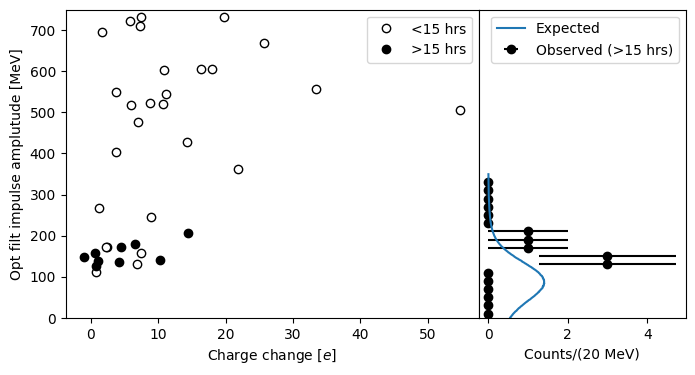

In [ ]:
## plot the reconstructed impulse amplitude versus the charge change
ymax = 750
fig, (scatter_ax, hist_ax) = plt.subplots(1, 2, figsize=(8, 4), width_ratios=[2,1])

plt.sca(scatter_ax)
plt.plot(pulse_data[:36,2], pulse_data[:36,1], 'ko', mfc='white', label="<15 hrs")
plt.plot(pulse_data[36:,2], pulse_data[36:,1], 'ko', label=">15 hrs")
xx = np.linspace(0,60)
#plt.plot(xx, 626/60*xx + 50, 'b:')
plt.ylim(0,ymax)
plt.xlabel("Charge change [$e$]")
plt.ylabel("Opt filt impulse amplutude [MeV]")
plt.legend()

hh, be = np.histogram(pulse_data[36:,1], bins=17, range=(0,340))
bc = be[:-1] + np.diff(be)/2
plt.sca(hist_ax)
hist_ax.errorbar(hh, bc, xerr=np.sqrt(hh), fmt='ko', label='Observed (>15 hrs)', zorder=0)
hist_ax.plot(exp_pdf*20*len(pulse_data[36:,0]), exp_bins, label='Expected')
plt.yticks([])
plt.ylim(0,ymax)
plt.xlabel("Counts/(20 MeV)")
plt.legend()

plt.subplots_adjust(wspace=0)


plt.savefig(plots_dir+"/amp_vs_charge_change_bp_%s.png"%file_label, dpi=300, bbox_inches="tight")

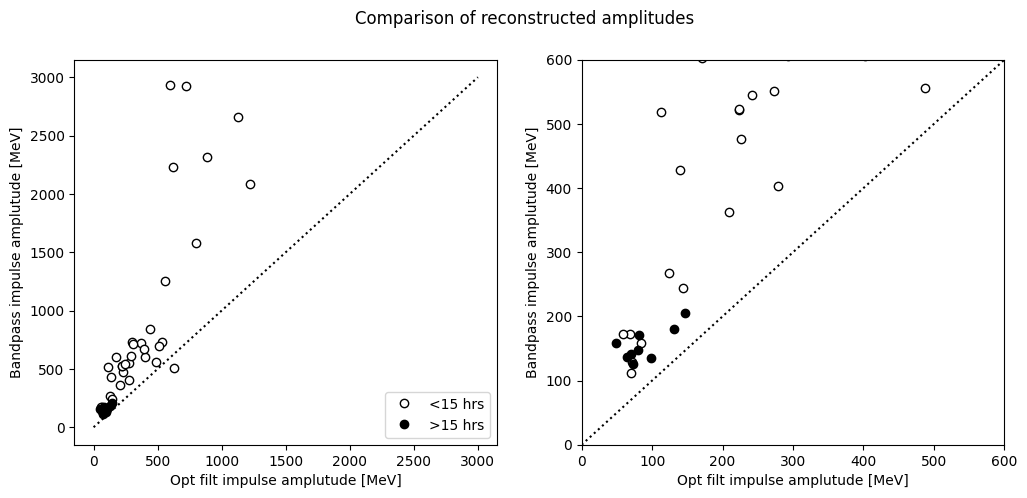

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(pulse_data[:36,0], pulse_data[:36,1], 'ko', mfc='white', label="<15 hrs")
plt.plot(pulse_data[36:,0], pulse_data[36:,1], 'ko', label=">15 hrs")
plt.plot([0,3000], [0,3000], 'k:')
plt.legend()

plt.xlabel("Opt filt impulse amplutude [MeV]")
plt.ylabel("Bandpass impulse amplutude [MeV]")

plt.subplot(1,2,2)
plt.plot(pulse_data[:36,0], pulse_data[:36,1], 'ko', mfc='white', label="<15 hrs")
plt.plot(pulse_data[36:,0], pulse_data[36:,1], 'ko', label=">15 hrs")
plt.plot([0,3000], [0,3000], 'k:')
plt.xlim(0,600)
plt.ylim(0,600)
plt.xlabel("Opt filt impulse amplutude [MeV]")
plt.ylabel("Bandpass impulse amplutude [MeV]")

plt.suptitle("Comparison of reconstructed amplitudes")

plt.savefig(plots_dir+"/opt_bp_comp_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [ ]:
## last, let's look at the photodiode data
cdat, attr, _ = bu.get_data('/Volumes/DATA/20230925/meas/1_PD/Alpha_0.h5')

Warning, got no keys for:  /Volumes/DATA/20230925/meas/1_PD/Alpha_0.h5


In [ ]:
print(data_list[0])

/Volumes/DATA/20230925/meas/1/LPmbar_xyzcool_0.h5


In [ ]:
import h5py
f = h5py.File('/Volumes/DATA/20230925/meas/1_PD/Alpha_2.h5','r')

In [ ]:
np.array(f['realtime'])
np.array(f['time'])

array([0.00000e+00, 3.20000e-08, 6.40000e-08, ..., 5.24192e-04,
       5.24224e-04, 5.24256e-04])

In [ ]:
f.keys()

<KeysViewHDF5 ['NFFT', 'communicate_time', 'realtime', 'time', 'voltage']>

In [ ]:
np.array(f['realtime'])

array(b'20:29:03.762598', dtype=object)

In [ ]:
np.array(f['communicate_time'])

array(2710.781093)

In [ ]:
remake_files = False
importlib.reload(bu)

if(remake_files):
    pdf = PdfPages(os.path.join(plots_dir, "candidate_alpha_det_%s.pdf"%file_label))

    for j,idx in enumerate(np.unique(np.floor(file_idx_of_charge_changes))):
        print("working on file: ", int(idx))
        #if(j>2): break
        step_idx = np.floor(step_times[:,0]).astype(int).tolist().index(int(idx))
        step_time = step_times[step_idx,1]
        if(step_time <= 0): step_time = 50

        cfile = data_list[int(idx)]
        cdat, attr, _ = bu.get_data(cfile)

        fig = bu.plot_step_with_alphas(cdat, attr, xrange=[step_time-xwind,step_time+xwind], cal_facs=[cal_fac_fine, cal_fac_coarse], 
                                    charge_range=[step_time-cwind,step_time+cwind])

        file_parts = '/'.join(cfile.split("/")[-2:])
        ctime = (attr['Time']-corr_vec[0,-1])/3600
        plt.suptitle("Candidate decay %d, time=%.1f hrs, file idx=%d, name=%s"%(j, ctime, int(idx), file_parts))
        try:
            pdf.savefig(dpi=75)
        except TimeoutError:
            print("Timeout error, trying again")
            pdf.savefig(dpi=75)
        plt.close(fig)

    pdf.close()


In [ ]:
importlib.reload(bu)

## equal noise
noise_vals = [noise, np.sqrt(2)*noise, np.sqrt(3)*noise] 

exp_bins, epdf_ndof = bu.calc_expected_spectrum(noise_vals)

ndof = [1,2,3]
plt.figure()
for n,epdf in zip(ndof, epdf_ndof):
    plt.plot(exp_bins, epdf, label="DOF = %d"%n)

plt.xlabel("Reconstructed momentum [MeV]")
plt.ylabel("Probability density [MeV$^{-1}$]")
plt.xlim(0,500)
plt.legend()



ValueError: too many values to unpack (expected 2)